In [1]:
import os
import glob
from tqdm import tqdm

import e2cnn

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import transforms
import PIL
from PIL import Image
#import imageio

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import configparser as ConfigParser

import utils
# Ipmport various network architectures
from networks import AGRadGalNet, DNSteerableLeNet, DNSteerableAGRadGalNet #e2cnn module only works in python3.7+
# Import various data classes
from datasets import FRDEEPF
from datasets import MiraBest_full, MBFRConfident, MBFRUncertain, MBHybrid
from datasets import MingoLoTSS, MLFR, MLFRTest

from sklearn.metrics import classification_report, roc_curve, auc
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")

## Generating Attention GIF

In [2]:
def draw_scalar_field(axs, scalarfield, r: int, contour):
    r'''
    Draw a scalar field
    '''
    
    D = 3
    
    m, M = scalarfield.min(), scalarfield.max()
    
    R = scalarfield.shape[0]
    angle = r * 2 * np.pi / R
    scalarfield = scalarfield[r, ...].squeeze()
    
    axs[0].clear()
    axs[0].imshow(domask(scalarfield.repeat(D, axis=0).repeat(D, axis=1), margin=8, fmt="image"), clim=(m, M))
    axs[0].contour(contour, 0, levels=[0.], cmap='cool')
    axs[0].set_title("Avg. Attention Map", fontdict={'fontsize': 30})

    stable_view = scipy.ndimage.rotate(scalarfield, -angle * 180.0 / np.pi, (-2, -1), reshape=False, order=2)
    
    axs[1].clear()
    axs[1].imshow(domask(stable_view.repeat(D, axis=0).repeat(D, axis=1), margin=8, fmt="image"), clim=(m, M))
    axs[1].contour(contour, 0, levels=[0.], cmap='cool')
    axs[1].set_title("Stabilized View", fontdict={'fontsize': 30})
    print(f"contour shape: {contour.shape}")
    print(f"image2 shape: {domask(scalarfield.repeat(D, axis=0).repeat(D, axis=1), margin=8, fmt='image').shape}")
    print(f"image2 shape: {domask(stable_view.repeat(D, axis=0).repeat(D, axis=1), margin=8, fmt='image').shape}")
    

def draw_vector_field(axs, vectorfield, r: int):
    r'''
    Draw a vector field
    '''
    
    D = 21
    extent = 0, vectorfield.shape[1], 0, vectorfield.shape[2]
    
    mask = build_mask(D * vectorfield.shape[1], margin=2).numpy().transpose(0, 2, 3, 1).squeeze()
    
    R = vectorfield.shape[0]
    angle = r * 2 * np.pi / R
    
    norms = np.sqrt((vectorfield ** 2).sum(axis=3))
    m, M = norms.min(), norms.max()
    
    vectorfield = vectorfield[r, ...]
    norms = norms[r, ...]
    
    X = range(D // 2, D * extent[1], D)
    Y = range(D // 2, D * extent[3], D)
    
    submask = mask[D // 2:D * extent[1]:D, D // 2:D * extent[3]:D]
    
    axs[0].clear()
    sf = axs[0].imshow(domask(norms.repeat(D, axis=0).repeat(D, axis=1), fmt='image'))
    sf.set_clim(m, M)
    vf = axs[0].quiver(X, Y, vectorfield[:, :, 0] * submask, vectorfield[:, :, 1] * submask, color="green", units="xy",
                       width=1)
    axs[0].set_title("feature field", fontdict={'fontsize': 30})
    
    stable_view = scipy.ndimage.rotate(vectorfield, -angle * 180.0 / np.pi, (-3, -2), reshape=False, order=2)
    
    rm = rot_matrix(-angle)
    stable_view = np.einsum("oc,xyc->xyo", rm, stable_view)
    stable_norms = np.sqrt((stable_view ** 2).sum(axis=2))
    
    axs[1].clear()
    sf = axs[1].imshow(domask(stable_norms.repeat(D, axis=0).repeat(D, axis=1), fmt='image'))
    sf.set_clim(m, M)
    vf = axs[1].quiver(Y, X, stable_view[:, :, 0] * submask, stable_view[:, :, 1] * submask, color="green", units='xy',
                       width=1)
    axs[1].set_title("stabilized view", fontdict={'fontsize': 30})


def quiver(ax, X, Y, U, V):
    scale = 1. / 20.
    X, Y = np.meshgrid(X, Y)
    mask = V ** 2 + U ** 2 > 1e-3
    ax.quiver(X[mask], Y[mask], U[mask], V[mask], color="forestgreen", angles='xy', units="xy", scale=scale, width=1.3)


def draw_mixed_field(axs, featurefield, r):
    r'''
    Draw a field containing a scalar field and a vector field
    '''
    
    D = 3
    V = 3
    
    extent = 0, D * featurefield.shape[1], 0, D * featurefield.shape[2]
    
    mask = build_mask(featurefield.shape[1], margin=8).numpy().transpose(0, 2, 3, 1).squeeze()
    
    R = featurefield.shape[0]
    angle = r * 2 * np.pi / R
    
    scalarfield = featurefield[:, ..., 0]
    m, M = scalarfield.min(), scalarfield.max()
    
    vectorfield = featurefield[r, ..., 1:]
    scalarfield = featurefield[r, ..., 0]
    featurefield = featurefield[r, ...]
    
    X = range(V * D // 2, extent[1], V * D)
    Y = range(V * D // 2, extent[3], V * D)
    
    submask = mask[V // 2:extent[1]:V, V // 2:extent[3]:V]
    
    axs[0].clear()
    sf = axs[0].imshow(domask(scalarfield.repeat(D, axis=0).repeat(D, axis=1), margin=8, fmt="image"))
    sf.set_clim(m, M)
    quiver(axs[0],
           X, Y,
           vectorfield[V // 2:extent[1]:V, V // 2:extent[3]:V, 0] * submask,
           vectorfield[V // 2:extent[1]:V, V // 2:extent[3]:V, 1] * submask,
           )
    axs[0].set_title("Avg. Attention Map", fontdict={'fontsize': 30})
    
    stable_view = scipy.ndimage.rotate(featurefield, -angle * 180.0 / np.pi, (-3, -2), reshape=False, order=2)
    
    stable_vectorfield = stable_view[..., 1:]
    stable_scalarfield = stable_view[..., 0]
    
    rm = rot_matrix(-angle)
    stable_vectorfield = np.einsum("oc,xyc->xyo", rm, stable_vectorfield)
    
    axs[1].clear()
    sf = axs[1].imshow(domask(stable_scalarfield.repeat(D, axis=0).repeat(D, axis=1), margin=8, fmt="image"))
    sf.set_clim(m, M)
    quiver(axs[1],
           X, Y,
           stable_vectorfield[V // 2:extent[1]:V, V // 2:extent[3]:V, 0] * submask,
           stable_vectorfield[V // 2:extent[1]:V, V // 2:extent[3]:V, 1] * submask,
           )
    axs[1].set_title("Stabilized View", fontdict={'fontsize': 30})


def build_gcnn(N: int, output: str):
    r'''
    Build an encoder-decoder model equivariant to N rotations.
    ``output`` speicifies the type of output field of the model, which will then be used for the animation.
    '''
    
    # build the g-space for N rotations
    if N == 1:
        gc = TrivialOnR2()
    else:
        gc = Rot2dOnR2(N)

    # the input contains 3 scalar channels (RGB colors)
    r1 = FieldType(gc, [gc.trivial_repr]*3)
    
    # let's build a few inner layers
    # we will build a small encoder-decoder convolutional architecture
    layers = []

    r2 = FieldType(gc, [gc.regular_repr] * 8)
    cl1 = R2Conv(r1, r2, 5,  bias=True, padding=0)
    layers.append(cl1)
    layers.append(ELU(layers[-1].out_type, inplace=True))
    
    for i in range(3):
        # every two layers we downsample the feature map
        if i % 2 == 0:
            layers.append(PointwiseAvgPoolAntialiased(layers[-1].out_type, 0.66, stride=2))
        cl = R2Conv(r2, r2, 5, bias=True, padding=0)
        layers.append(cl)
        layers.append(ELU(layers[-1].out_type, inplace=True))
    
    for i in range(3):
        # every two layers we upsample the feature map
        if i % 2 == 0:
            layers.append(R2Upsampling(layers[-1].out_type, 2, align_corners=True))
        
        cl = R2Conv(r2, r2, 5, bias=True, padding=0)
        layers.append(cl)
        layers.append(ELU(layers[-1].out_type, inplace=True))
    
    # finally, map to the output field which will then be visualized
    so2 = SO2(1)
    
    # A vector field contains two channels transforming according to the frequency-1 irrep of SO(2)
    # (the common 2x2 rotation matrices)
    # the representation needs to be restricted to the group of N discrete rotations considered
    vector_f = FieldType(gc, [so2.irrep(1).restrict(N)])
    
    # A scalar field contains one channel transforming according to the trivial representation of SO(2)
    # i.e., its values do not change when a rotation is applied
    # the representation needs to be restricted to the group of N discrete rotations considered
    scalar_f = FieldType(gc, [so2.trivial_representation.restrict(N)])
    
    # build the output field type
    if output == "vector":
        r3 = vector_f
    elif output == "scalar":
        r3 = scalar_f
    elif output == "both":
        # in this case we outputs both a scalar and a vector field
        r3 = scalar_f + vector_f
    else:
        raise ValueError()
    
    cl2 = R2Conv(layers[-1].out_type, r3, 5, padding=0, bias=False)
    layers.append(cl2)
    
    # for visualization purpose, apply a non-linearity on the output to restrict the range of values it takes
    if output == "vector":
        layers.append(NormNonLinearity(layers[-1].out_type, "squash", bias=False))
    elif output == "scalar":
        layers.append(SequentialModule(InnerBatchNorm(r3), PointwiseNonLinearity(r3, "p_sigmoid")))
    elif output == "both":
        labels = ["scalar", "vector"]
        nnl = [
            (
                SequentialModule(InnerBatchNorm(scalar_f), PointwiseNonLinearity(scalar_f, "p_sigmoid")),
                "scalar"
            ),
            (
                NormNonLinearity(vector_f, "squash", bias=False),
                "vector"
            ),
        ]
        layers.append(MultipleModule(r3, labels, nnl))
    else:
        raise ValueError()

    model = SequentialModule(*layers)
    return model

In [8]:
# https://github.com/QUVA-Lab/e2cnn/blob/master/visualizations/animation.py
import numpy as np
from e2cnn.nn import *
from e2cnn.group import *
from e2cnn.gspaces import *

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

import matplotlib.animation as manimation

from skimage.transform import resize
import scipy.ndimage

import torch
from typing import Union

plt.rcParams['image.cmap'] = 'magma'
plt.rcParams['axes.titlepad'] = 30


# the irrep of frequency 1 of SO(2) produces the usual 2x2 rotation matrices
rot_matrix = SO2(1).irrep(1)


def build_mask(s: int, margin: float = 2., dtype=torch.float32):
    mask = torch.zeros(1, 1, s, s, dtype=dtype)
    c = (s - 1) / 2
    t = (c - margin / 100. * c) ** 2
    sig = 2.
    for x in range(s):
        for y in range(s):
            r = (x - c) ** 2 + (y - c) ** 2
            if r > t:
                mask[..., x, y] = np.exp((t - r) / sig ** 2)
            else:
                mask[..., x, y] = 1.
    return mask


def domask(x: Union[np.ndarray, torch.Tensor], margin=2, fmt="torch"):
    if fmt == "image":
        s = x.shape[0]
        mask = build_mask(s, margin)
        mask = mask.permute(0, 2, 3, 1).squeeze()
    else:
        s = x.shape[2]
        mask = build_mask(s, margin)
    
    if isinstance(x, np.ndarray):
        mask = mask.numpy()
        
    # use an inverse mask to create a white background (value = 1) instead of a black background (value = 0)
    return mask * x + 1. - mask


def animate(model: EquivariantModule,
            image: Union[str, np.ndarray],
            outfile: str,
            drawer: callable,
            R: int = 72,
            S: int = 150,
            duration: float = 10.,
            figsize=(21, 10),
            RGB: bool=False,
            ):
    r'''
    
    Build a video animation
    
    Args:
        model: the equivariant model
        image: the input image
        outfile: name of the output file
        drawer: method which plots the output field. use one of the methods ``draw_scalar_field``, ``draw_vector_field`` or ``draw_mixed_field``
        R: number of rotations of the input to render, i.e. number of frames in the video
        S: size the input image is downsampled to before being fed in the model
        duration: duration (in seconds) of the video
        figsize: shape of the video (see matplotlib.pyplot.figure())
        RGB: Whether or not to output attention maps as RGB images
    '''
    
    fig, axs = plt.subplots(1, 3, figsize=figsize)
    fig.set_tight_layout(True)
    
    device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
    model.to(device)
    model.eval()
    
    if isinstance(image, str):
        image = mpimg.imread(image).transpose((2, 0, 1))
    image = image[np.newaxis, :, :, :]
    _, C, w, h = image.shape
    
    # resize the image to have a squared shape
    # the image is initially upsampled to (up to) 4 times the specified size S
    # rotations are performed at this higher resolution and are later downsampled to size S
    # this helps reducing the interpolation artifacts for rotations which are not multiple of pi/2
    T = max(4 * S + 1, 513)
    image = resize(image, (1, C, T, T), anti_aliasing=True)
    C = np.min([C, 3])
    
    original_inputs = []
    
    for r in range(R):
        # Rotate the image
        # N.B.: this only works for trivial (i.e. scalar) input fields like RGB images.
        # In case vector fields are used in input, one should also rotate the channels using the group representation
        # of the corresponding FieldType
        rot_input = scipy.ndimage.rotate(image, r * 360.0 / R, (-2, -1), reshape=False, order=2)
        
        # discard non-RGB channels
        rot_input = rot_input[:, :C, ...]

        original_inputs.append(rot_input)

    original_inputs = np.concatenate(original_inputs, axis=0)
    
    # mask the input images to remove the pixels which would be moved outside the grid by a rotation
    original_inputs *= build_mask(T, margin=5.2).numpy()

    # downsample the images
    inputs = resize(original_inputs, (original_inputs.shape[0], C, S, S), anti_aliasing=True)
    
    rotated_input = torch.tensor(inputs, dtype=torch.float32)
    rotated_input *= build_mask(S, margin=5.2)### ????
    
    # normalize the colors of the images before feeding them into the model
    rotated_input -= rotated_input[0, ...].view(C, -1).mean(dim=1).view(1, C, 1, 1)
    rotated_input /= rotated_input[0, ...].view(C, -1).std(dim=1).view(1, C, 1, 1)
    
    del inputs
    
    rotated_input = rotated_input.to(device)
    # wrap the tensor in a GeometricTensor
    #rotated_input = GeometricTensor(rotated_input, model.in_type)


    # pass the images through the model to compute the output field
    with torch.no_grad():
        
        # In training mode, the batch normalization layers normalize the features with the batch statistics
        # This sometimes produces nicer output fields
        # model.train()
        mean = not RGB
        #output = model(rotated_input)
        amaps, amap_originals = utils.attention.attentions_func(
                rotated_input, 
                model,
                device=device,
                layer_no=3,
                layer_name_base='attention',
                mean=mean
        )
    
    # mask the inputs with a white background for visualization purpose
    original_inputs = domask(original_inputs, margin=5)
    rotated_input = domask(rotated_input.cpu().numpy(), margin=2)
    #amaps = amaps.transpose(0, 2, 3, 1)
    
    title_suppliment = "Avg. " if not RGB else ""
        
    # save each rotated image and its corresponding output in a different frame of the video
    for r in range(R):
        n = str(r)
        while len(n)<3:
            n = '0'+n
        
        # render the input image
        source = rotated_input[r, ...].transpose(1, 2, 0).squeeze()
        
        axs[0].clear()
        axs[0].imshow(source)
        axs[0].contour(source, 0, levels=[0.], cmap='cool')
        axs[0].set_title("Input", fontdict={'fontsize': 30})
        
        # render the output and the stabilized output
        #drawer(axs[1:], amaps, r, contour=source)
        
        m, M = amaps.min(), amaps.max()
        if RGB:
            amap = domask(amaps[r, ...].squeeze(), margin=2)
            amap = amap.squeeze().transpose(1, 2, 0)
        else:
            # If you want non masked, comment out the below
            amap = domask(amaps[r, ...].squeeze(), margin=2, fmt="image")
        
        axs[1].clear()
        axs[1].imshow(amap, clim=(m, M))
        #axs[1].contour(source, 0, levels=[0.], cmap='cool')
        axs[1].set_title(f"{title_suppliment}Attention Map", fontdict={'fontsize': 30})
        
        angle = r * 2 * np.pi/R
        stable_view = scipy.ndimage.rotate(amaps[r, ...].squeeze(), -angle * 180.0 / np.pi, (-2, -1), reshape=False, order=2)
        if RGB:
            stable_view = domask(stable_view, margin=2)
            stable_view = stable_view.squeeze().transpose(1, 2, 0)
        else:
            # If you want non masked, comment out the below
            stable_view = domask(stable_view, margin=2, fmt="image")
        
        axs[2].clear()
        axs[2].imshow(stable_view, clim=(m, M))
        axs[2].contour(rotated_input[0, ...].transpose(1, 2, 0).squeeze(), 0, levels=[0.], cmap='cool')
        axs[2].set_title("Stabilized View", fontdict={'fontsize': 30})
        
        for ax in axs:
            ax.axis('off')
        
        fig.set_tight_layout(True)
        plt.savefig(outfile.replace("*", n))

Files already downloaded and verified
starting for source 16 RGB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

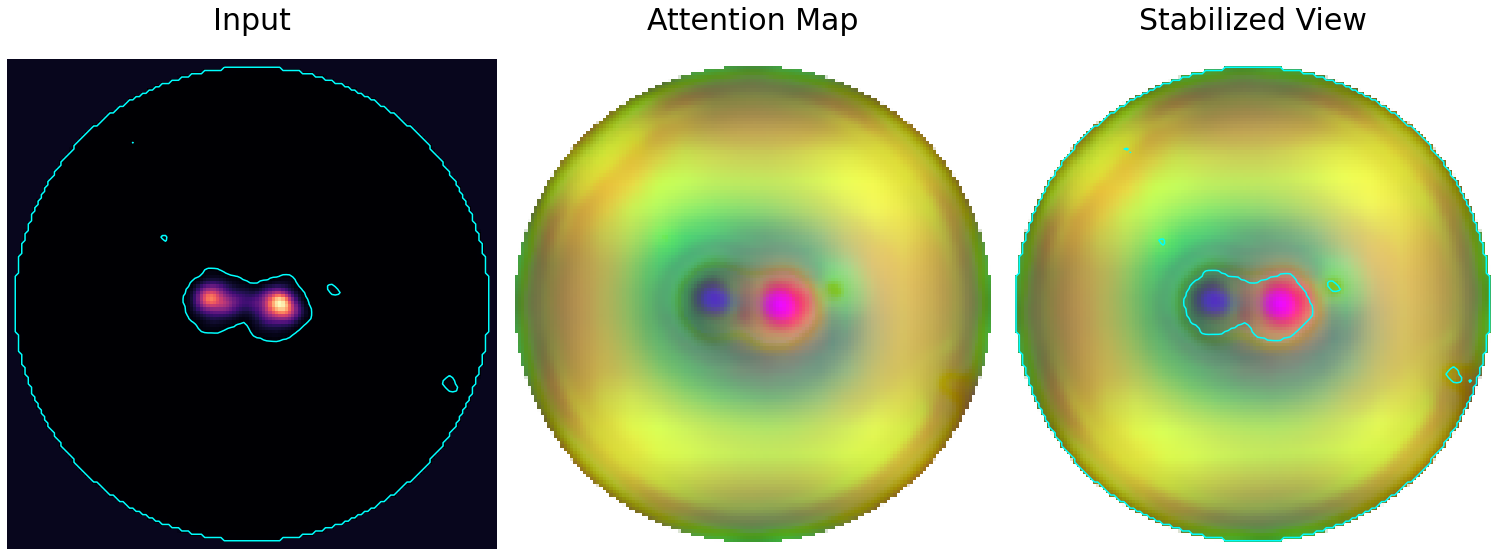

In [9]:
#output = "both"
#output = "vector"
output = "scalar"

# Load in my equivariant model
cfg = "5kernel_e2attentionmingo-RandAug.cfg"
cfg = "configs/"+cfg
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read(cfg)
path_supliment = config['data']['augment']
if path_supliment in ['True', 'False']:
    path_supliment=''
else:
    path_supliment+='/'
model = utils.utils.load_model(config, load_model='best', device=device, path_supliment=path_supliment)

# Load in test data / image
interesting_sources = [ # Must be sorted by total number for correct labelling [batch no, source no within given batch]
    [0,12],
    [0,13],
    [1,0],
    [1,5],
    [1,13],
    [1,14],
    [5,10]
]

interesting_sources = [
    [1,0]
]

imgs = []
labels = []
test_data_loader = utils.data.load(config, train=False, augmentation='None', data_loader=True)    # Prepare sources and labels
for idx, (test_data, l) in enumerate(test_data_loader):
    for idy, img in enumerate(test_data):
        if [idx,idy] in interesting_sources:
            imgs.append(img)
            labels.append(l[idy])

frames = 24*6
gif_duration_s = 6
duration = gif_duration_s/frames*1000 # duration of single image within gif (ms)

completed = []
for idx, image in enumerate(imgs):
    for color in ['RGB']:
        source_no = 16*interesting_sources[idx][0] + interesting_sources[idx][1]
        RGB_ = True if color=='RGB' else False
        if source_no in completed:
            pass
        else:
            print(f"starting for source {source_no} {color}")
            out_path = f"/raid/scratch/mbowles/EquivariantSelfAttention/figures/animation_frames/{color}amap_MingoLotSS{source_no}_FR{labels[idx]+1}_*.png"
            # build the animation
            animate(model, image, out_path, draw_scalar_field, R=frames, S=150, RGB=RGB_)
            
            # produce final video using ffmpeg command:
            #ffmpeg -framerate 24 -i animation_frames/amap_MingoLotSS16_FR2_%03d.png -pix_fmt yuv420p FILE_NAME.mp4
            #fp_out = f"/raid/scratch/mbowles/EquivariantSelfAttention/figures/{color}amap_MingoLotSS{source_no}_FR{labels[idx]+1}.gif"
            # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
            #img, *imgs = [Image.open(f) for f in sorted(glob.glob(out_path))]
            #img.save(fp=fp_out, format='GIF', append_images=imgs,
            #         save_all=True, duration=duration, loop=0)

starting for source 16 
starting for source 16 RGB


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

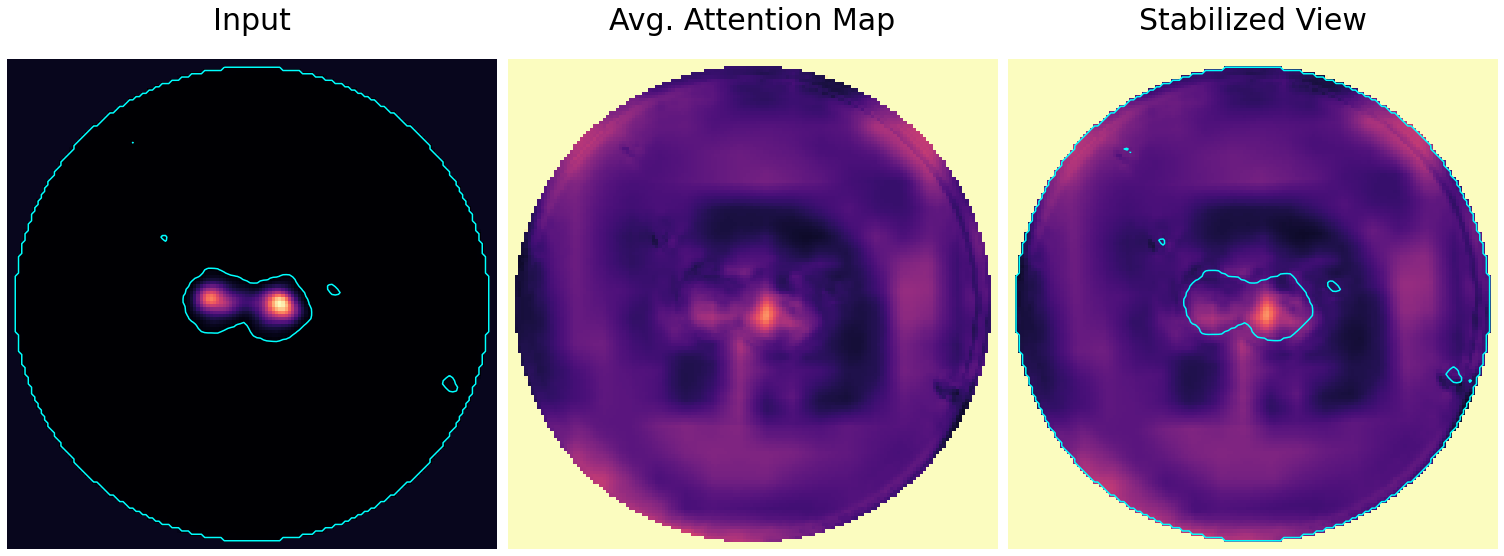

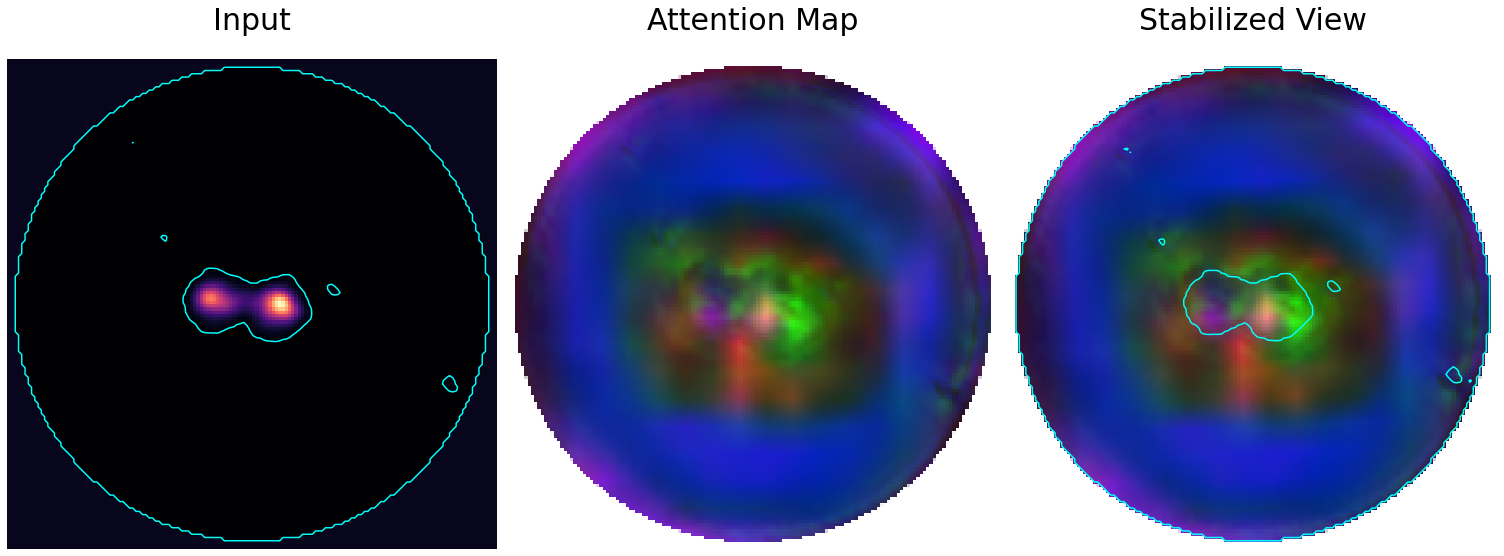

In [10]:
#output = "both"
#output = "vector"
output = "scalar"

# Load in my equivariant model
cfg = "bowles2021mingo-RandAug.cfg"
cfg = "configs/"+cfg
config = ConfigParser.ConfigParser(allow_no_value=True)
config.read(cfg)
path_supliment = config['data']['augment']
if path_supliment in ['True', 'False']:
    path_supliment=''
else:
    path_supliment+='/'
model = utils.utils.load_model(config, load_model='best', device=device, path_supliment=path_supliment)

for idx, image in enumerate(imgs):
    for color in ['', 'RGB']:
        source_no = 16*interesting_sources[idx][0] + interesting_sources[idx][1]
        RGB_ = True if color=='RGB' else False
        if source_no in completed:
            pass
        else:
            print(f"starting for source {source_no} {color}")
            out_path = f"/raid/scratch/mbowles/EquivariantSelfAttention/figures/animation_frames/{color}AGRadGalNetamap_MingoLotSS{source_no}_FR{labels[idx]+1}_*.png"
            # build the animation
            animate(model, image, out_path, draw_scalar_field, R=frames, S=150, RGB=RGB_)
            
            # produce final video using ffmpeg command:
            #ffmpeg -framerate 24 -i animation_frames/AGRadGalNetamap_MingoLotSS16_FR2_%03d.png -pix_fmt yuv420p FILE_NAME.mp4
            #fp_out = f"/raid/scratch/mbowles/EquivariantSelfAttention/figures/AGRadGalNet{color}amap_MingoLotSS{source_no}_FR{labels[idx]+1}.gif"
            # https://pillow.readthedocs.io/en/stable/handbook/image-file-formats.html#gif
            #img, *imgs = [Image.open(f) for f in sorted(glob.glob(out_path))]
            #img.save(fp=fp_out, format='GIF', append_images=imgs,
            #         save_all=True, duration=duration, loop=0)

Files already downloaded and verified


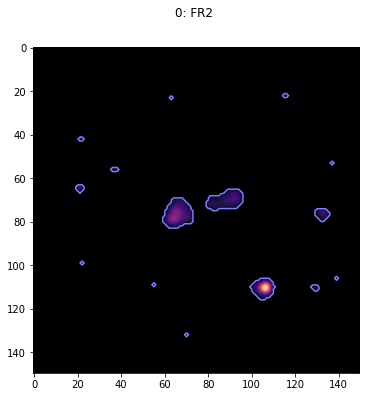

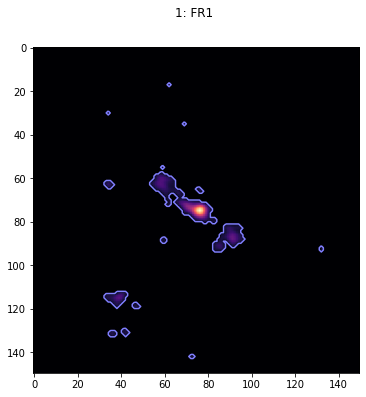

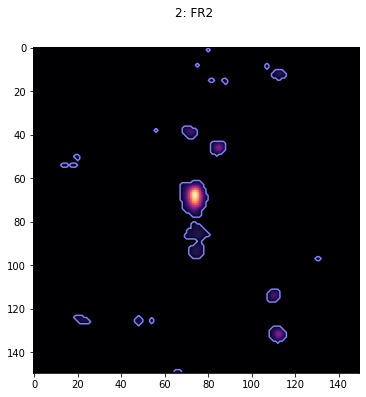

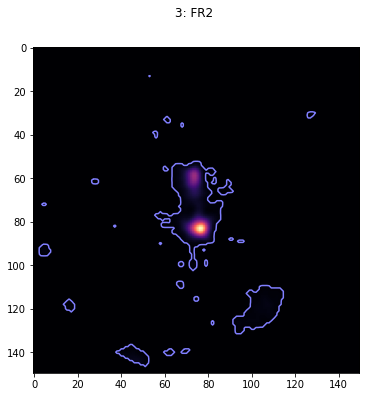

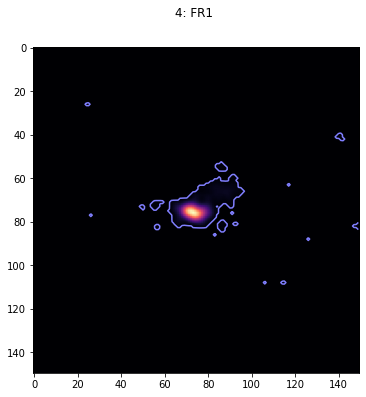

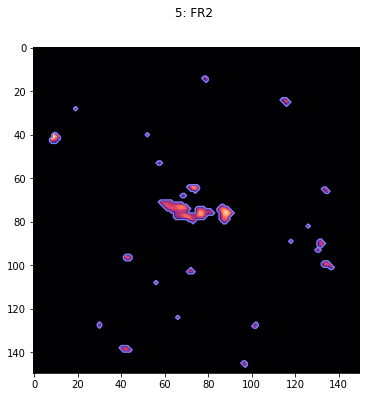

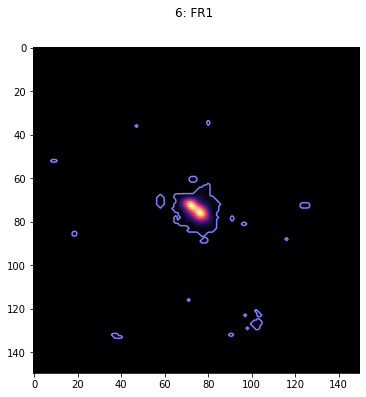

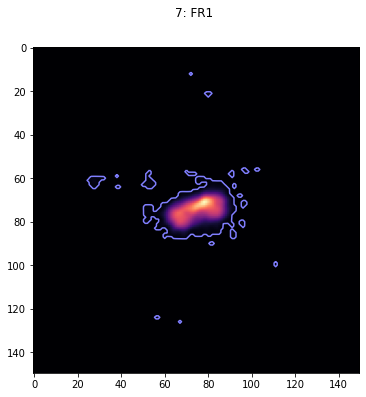

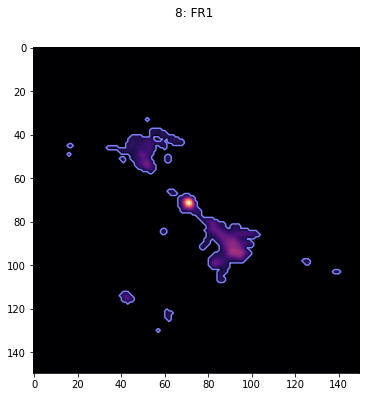

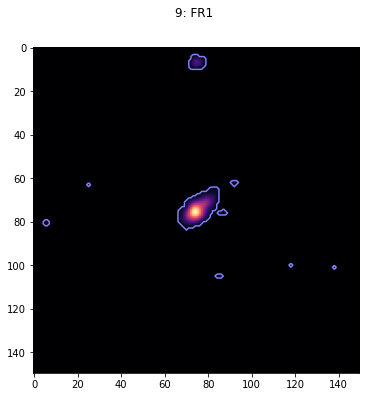

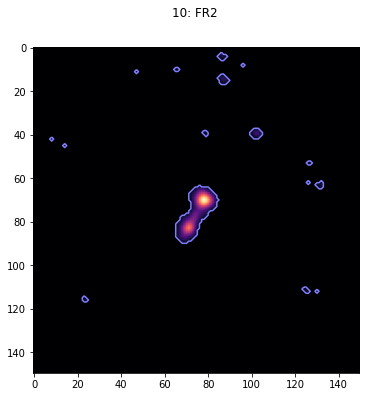

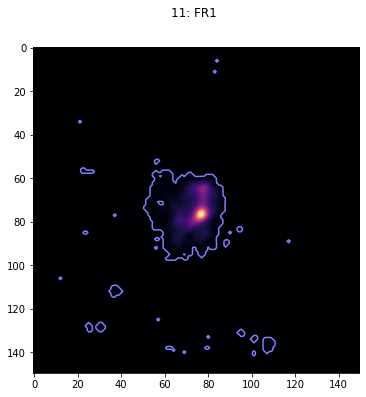

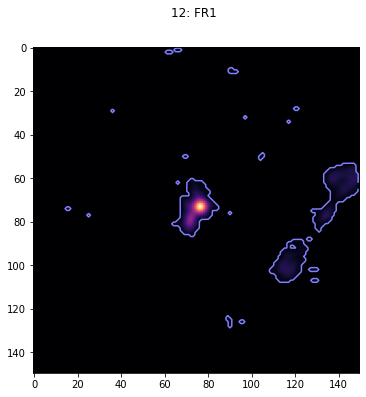

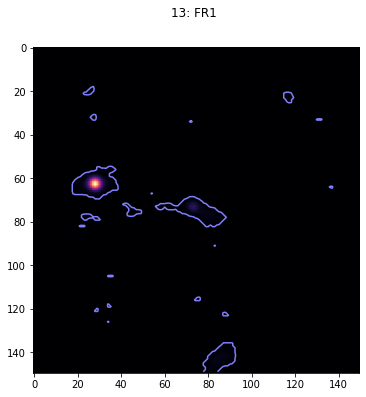

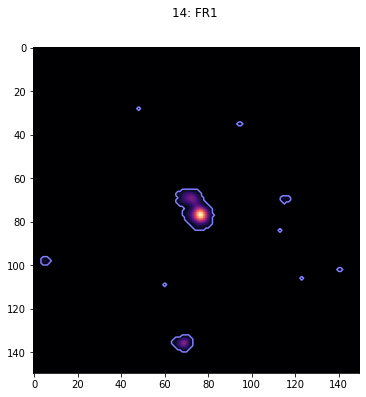

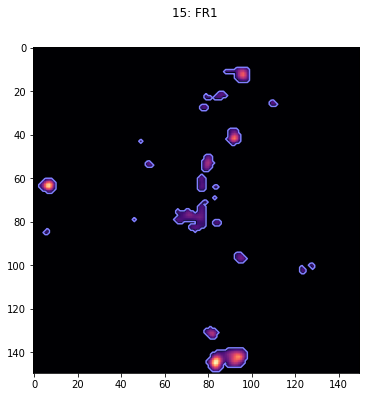

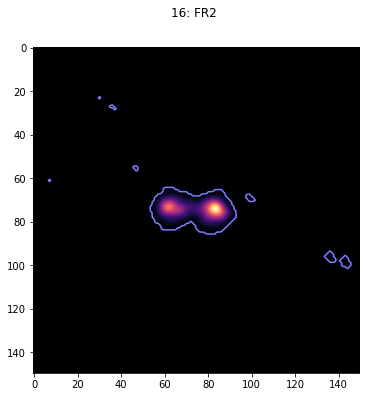

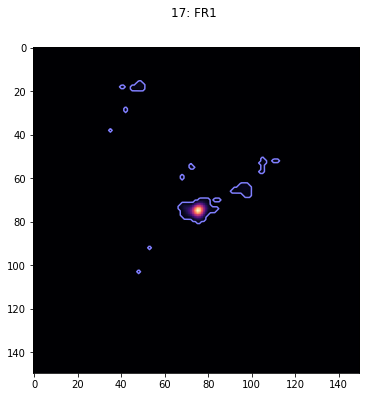

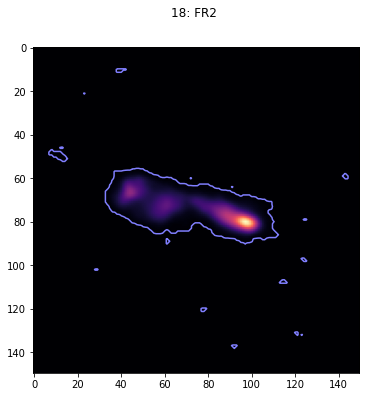

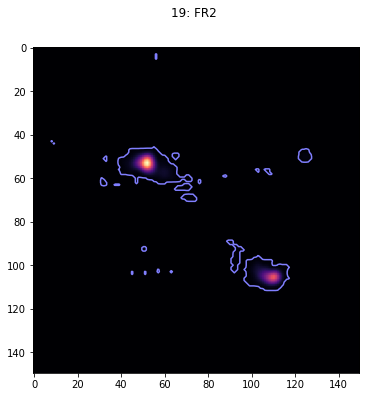

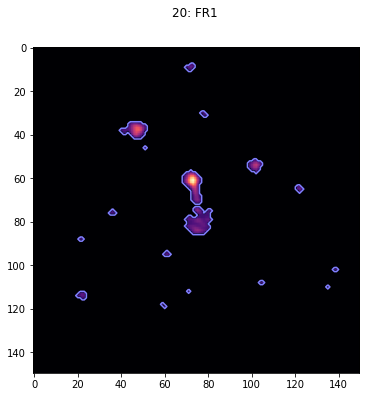

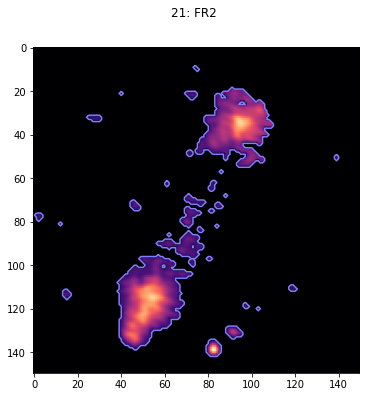

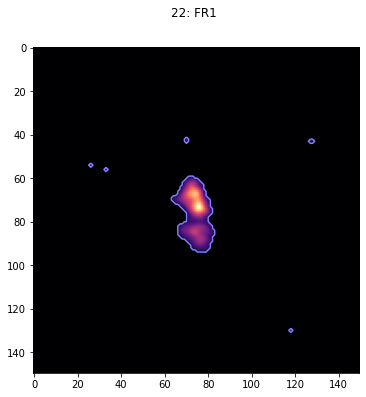

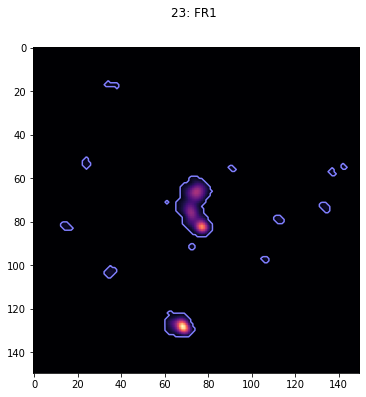

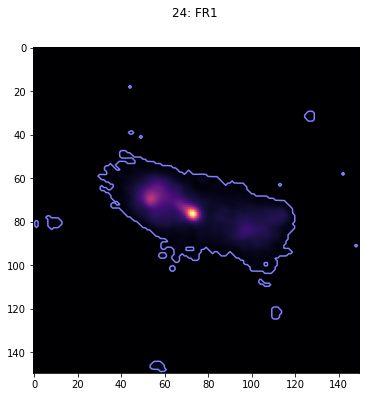

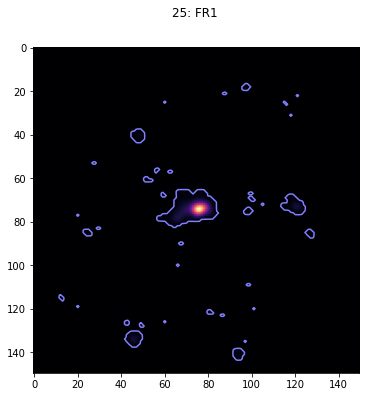

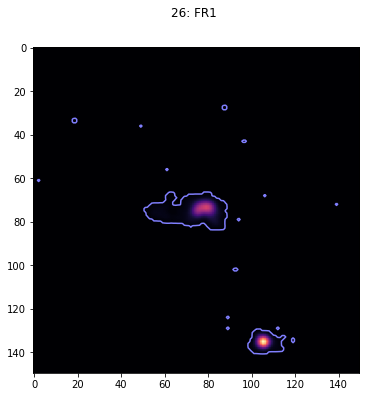

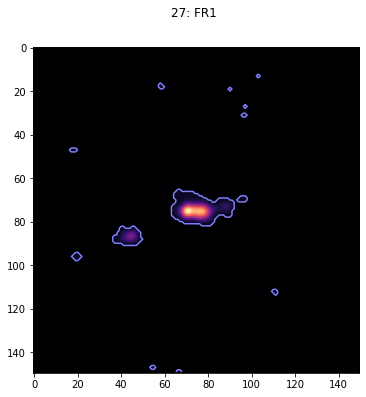

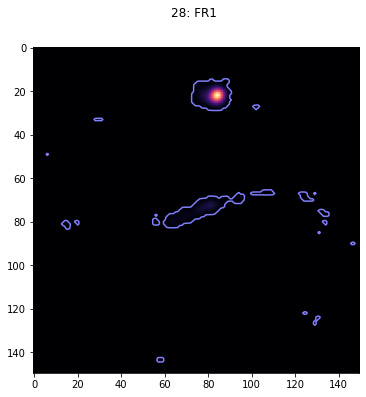

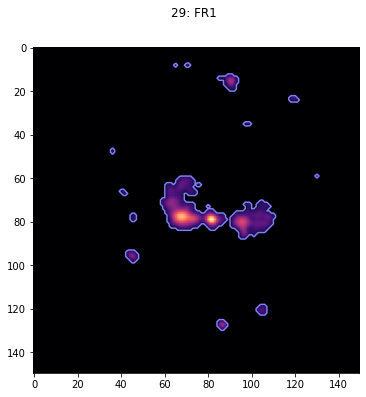

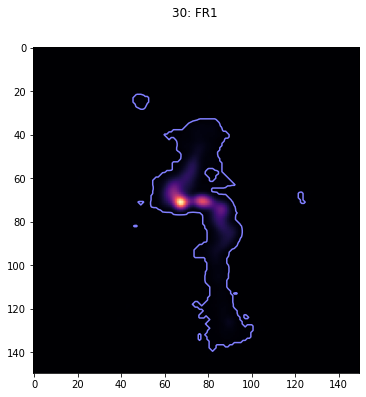

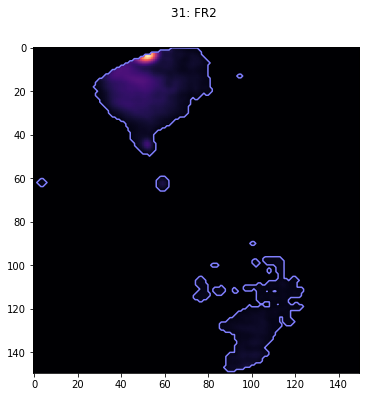

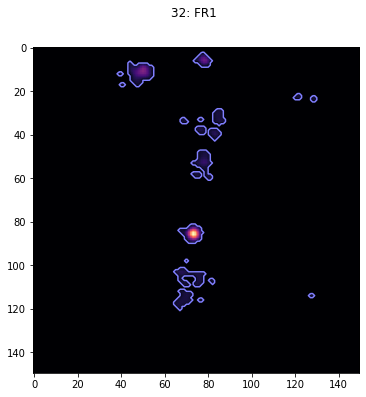

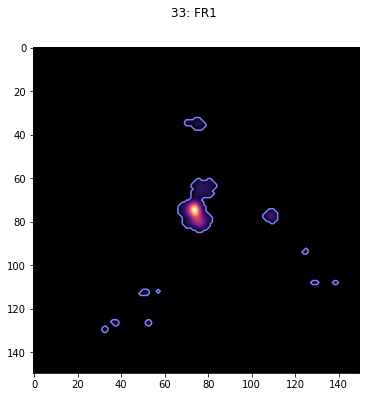

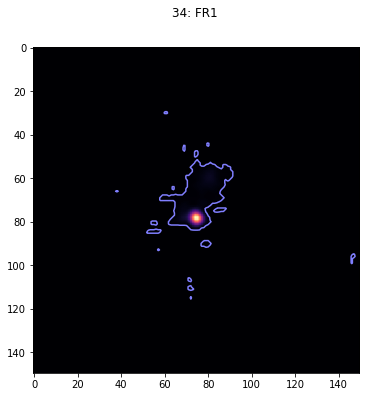

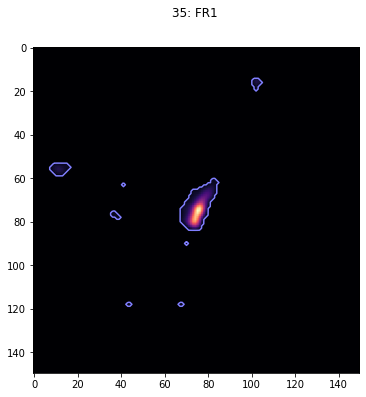

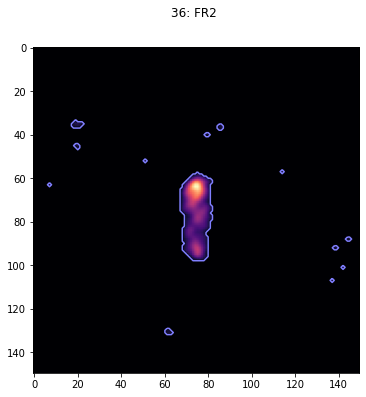

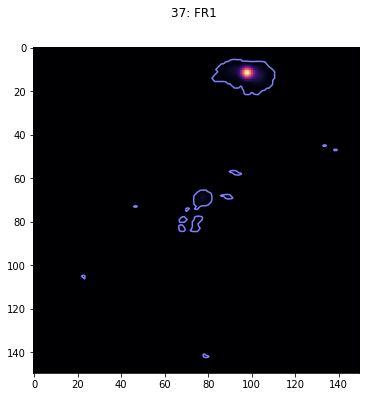

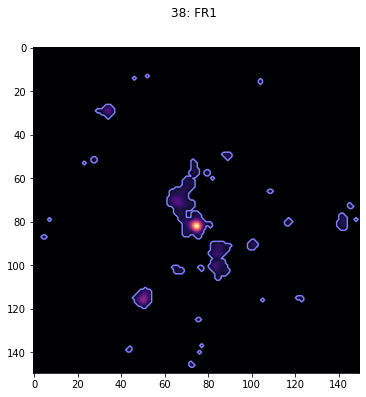

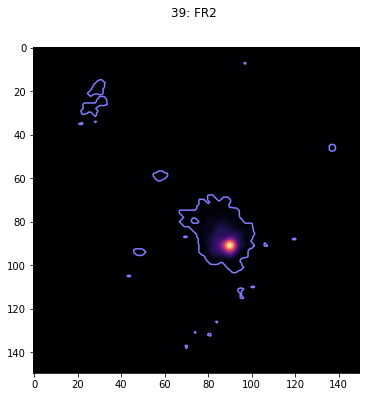

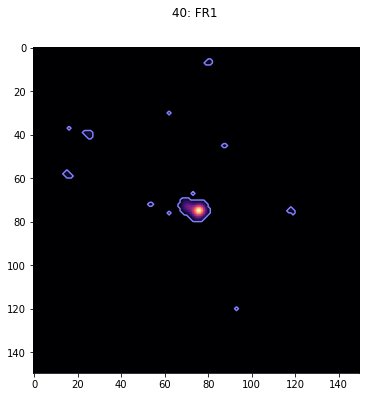

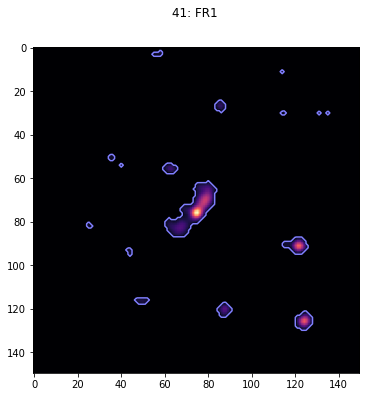

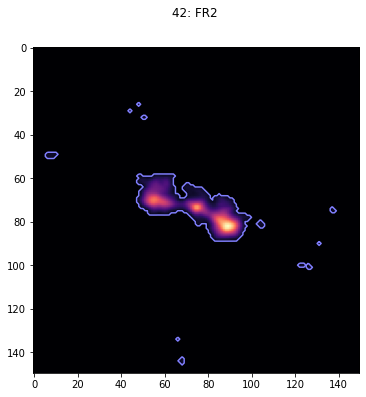

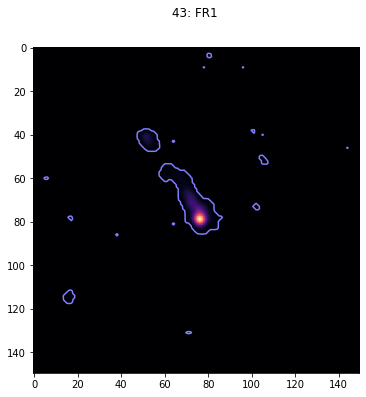

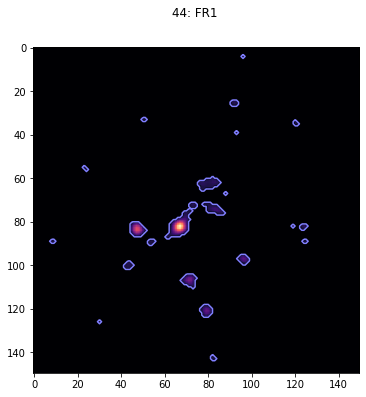

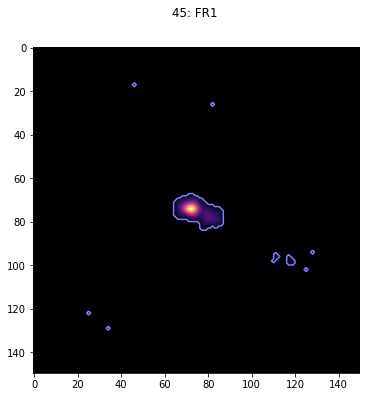

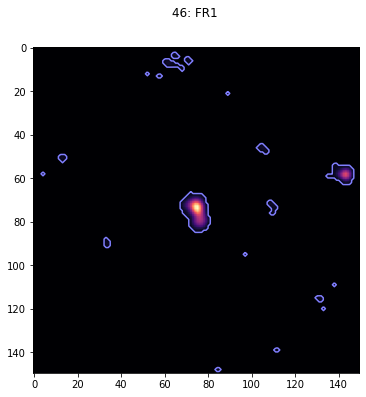

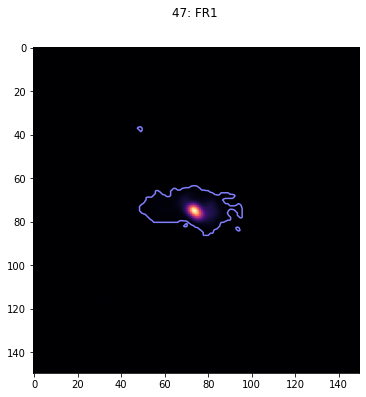

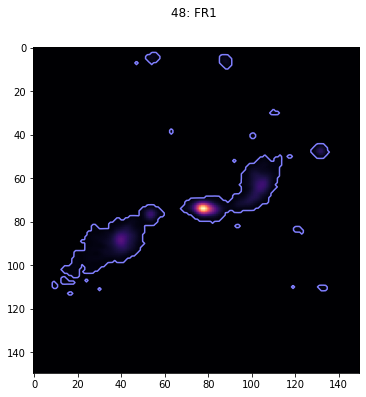

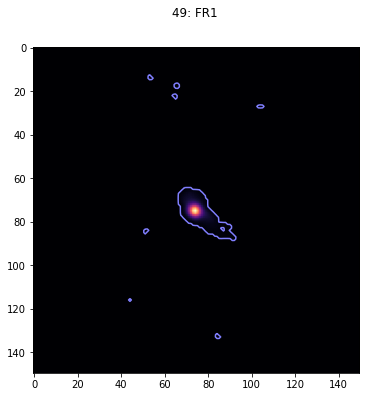

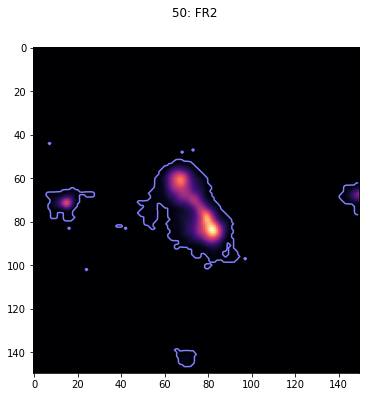

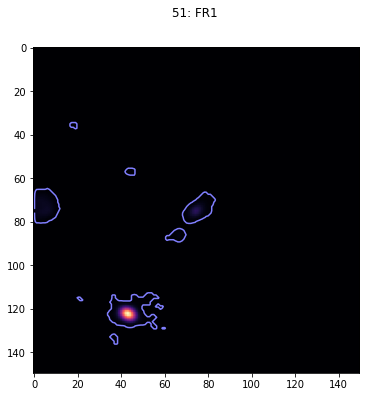

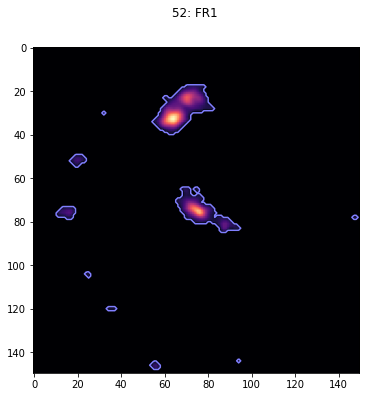

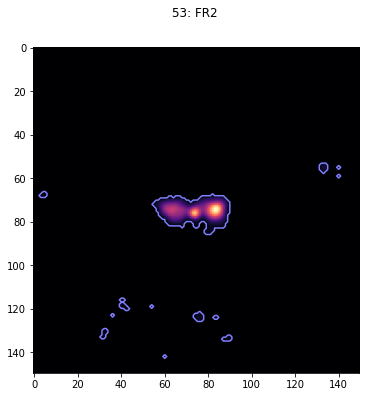

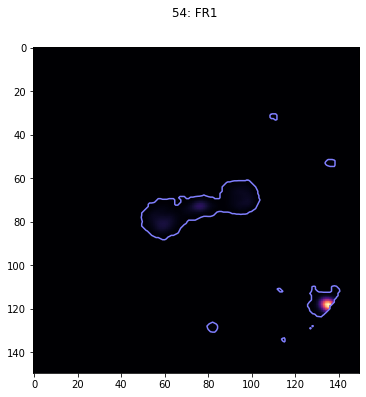

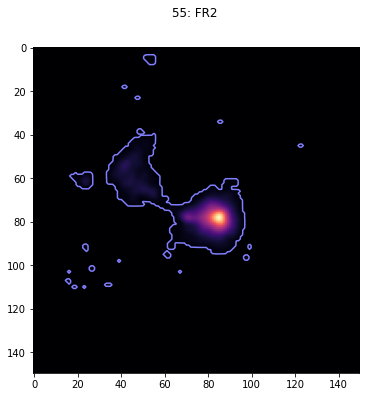

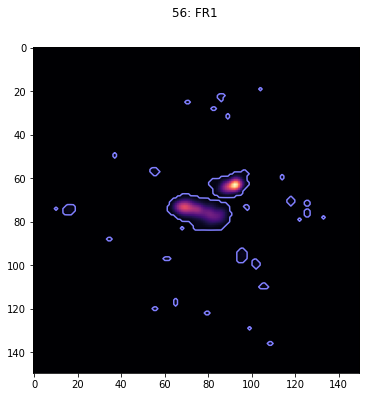

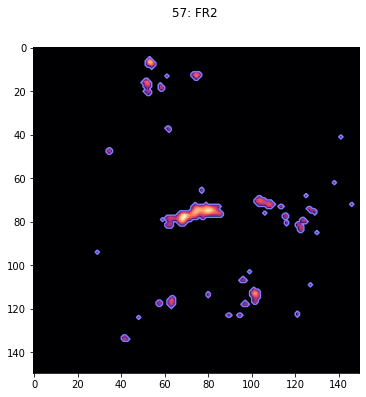

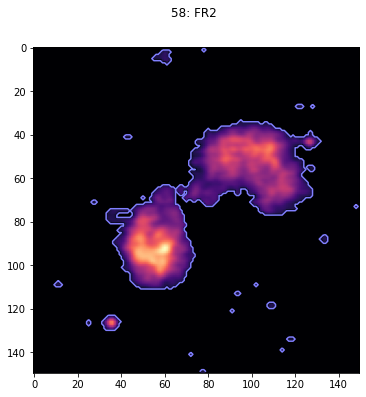

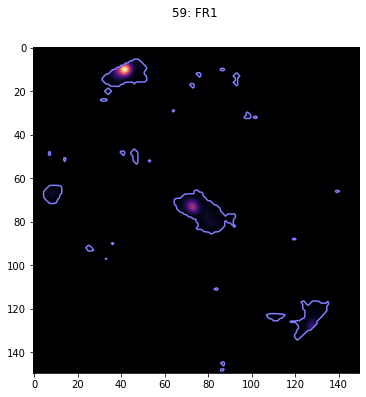

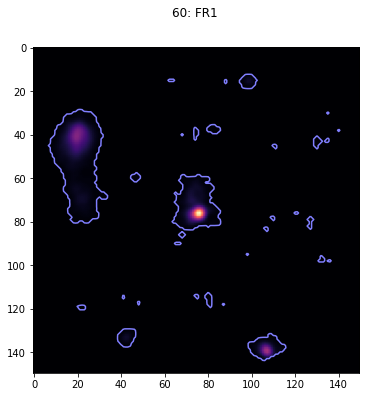

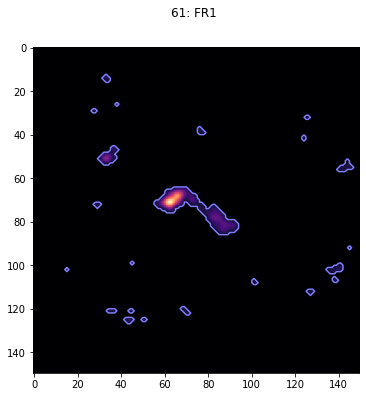

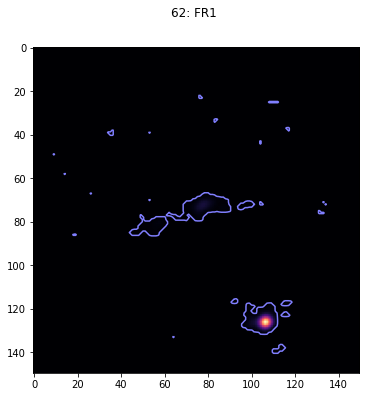

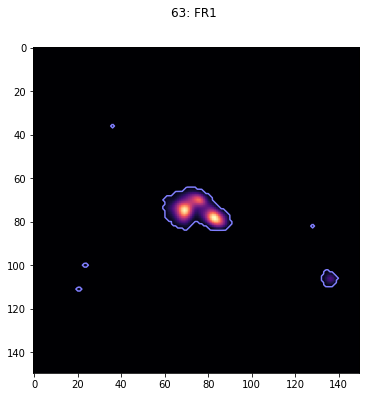

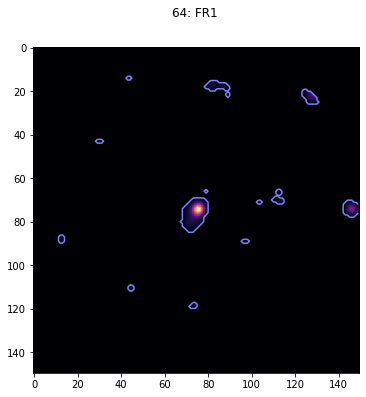

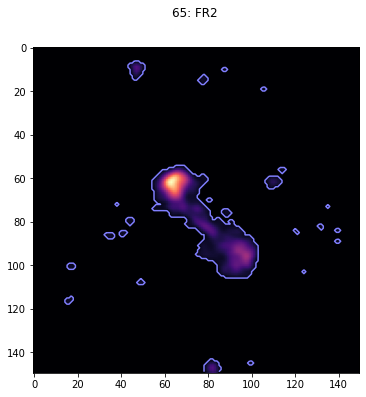

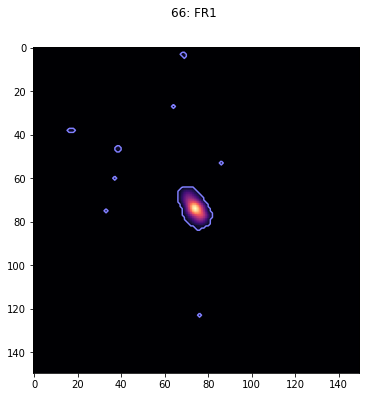

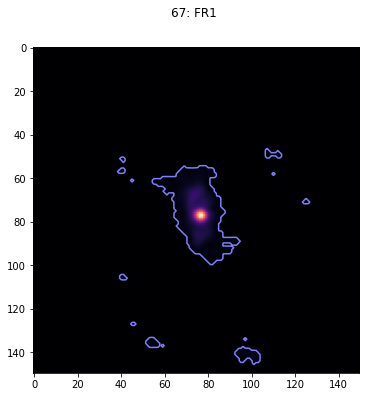

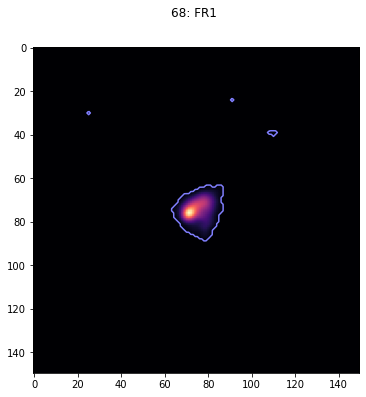

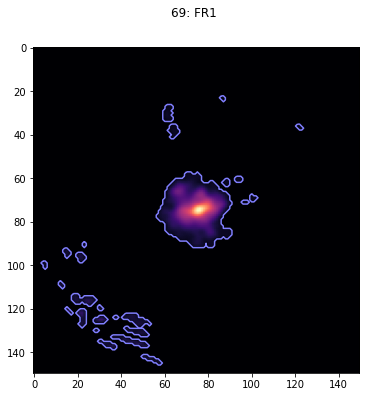

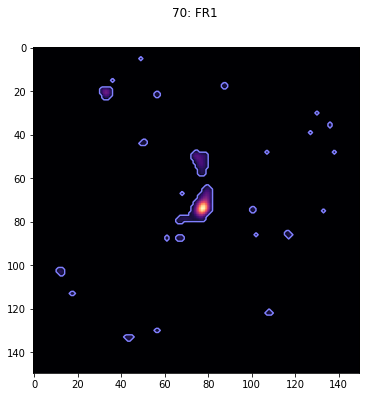

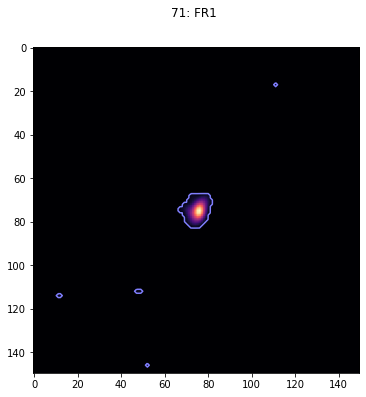

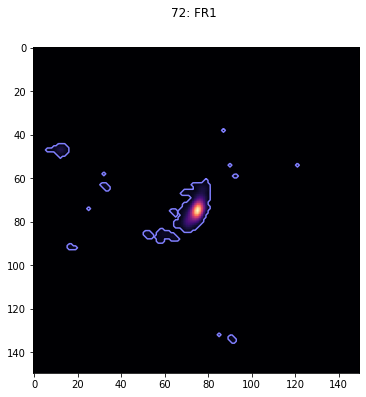

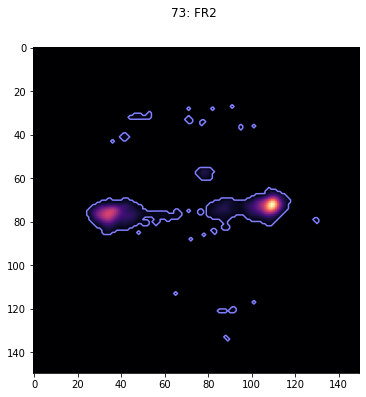

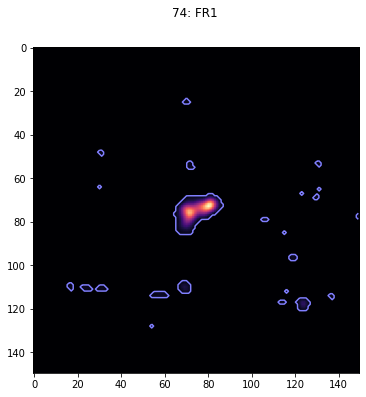

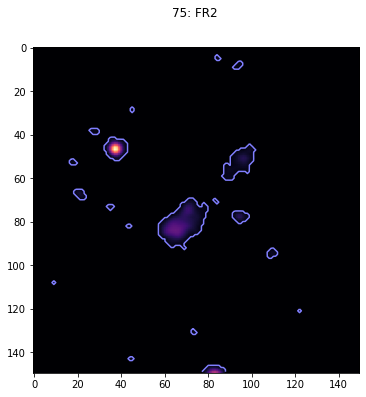

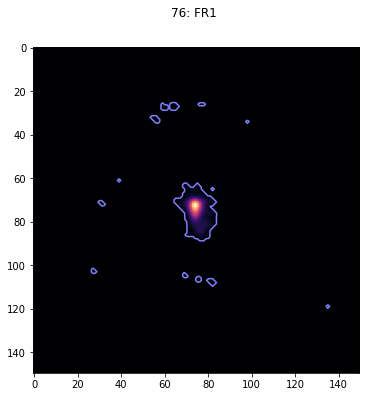

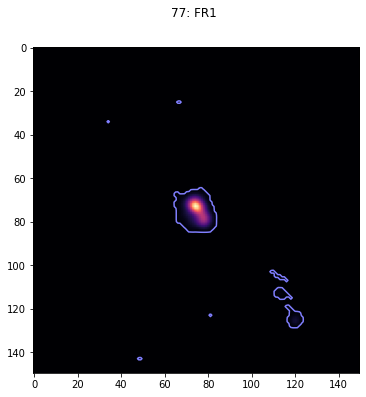

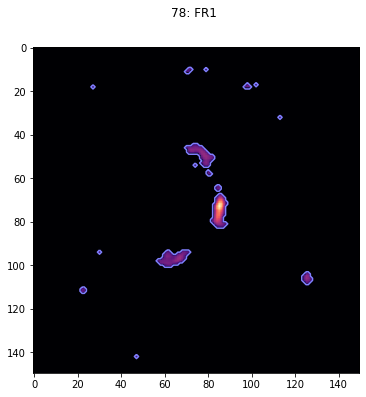

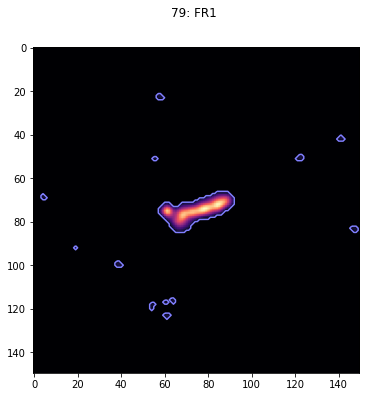

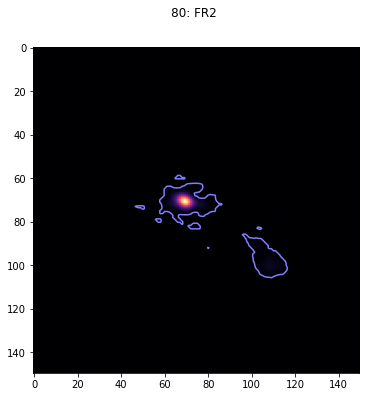

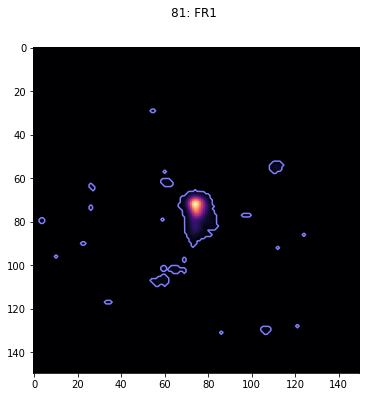

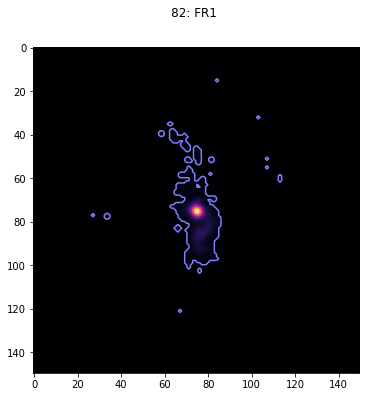

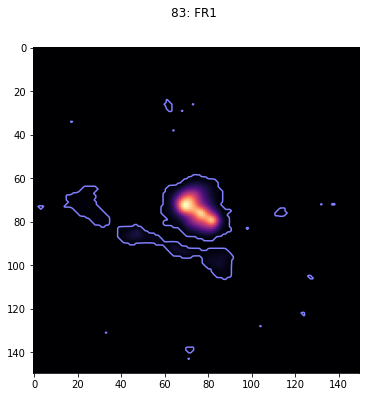

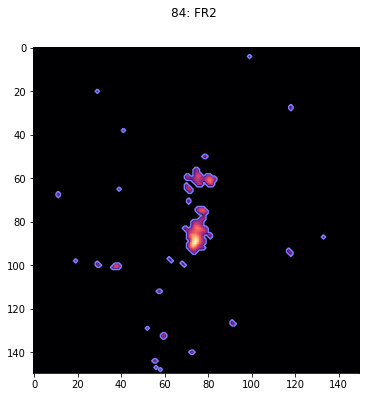

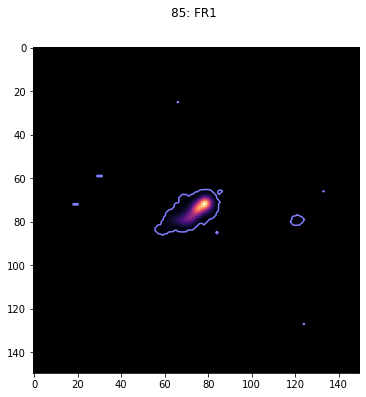

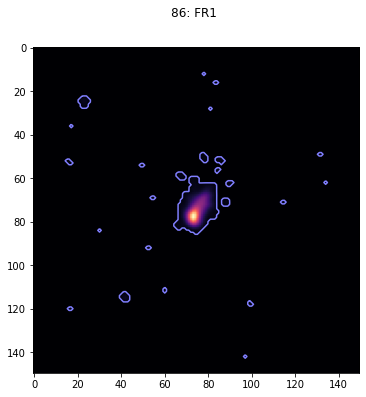

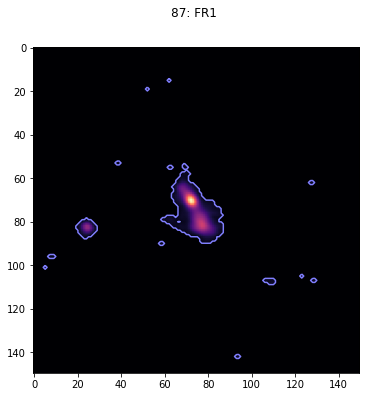

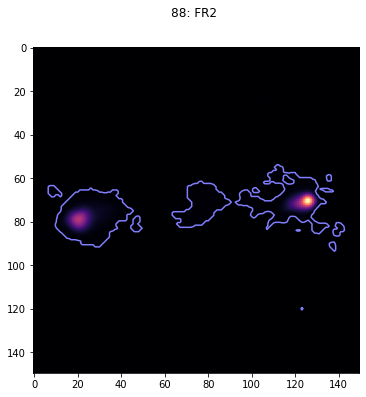

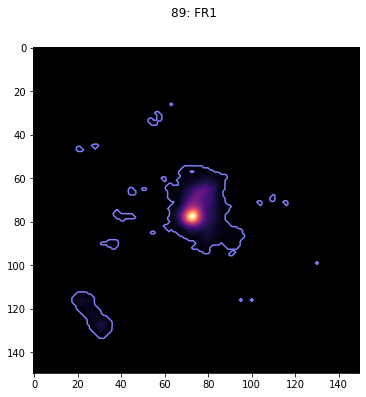

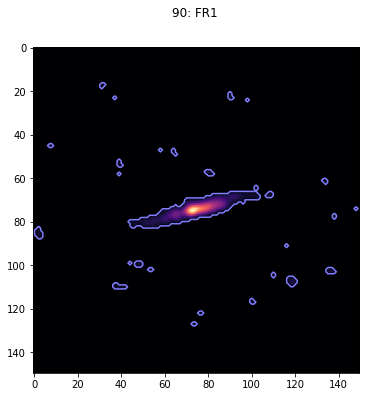

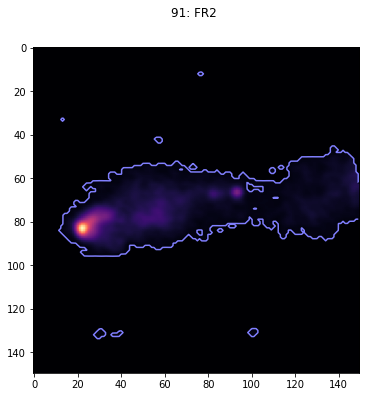

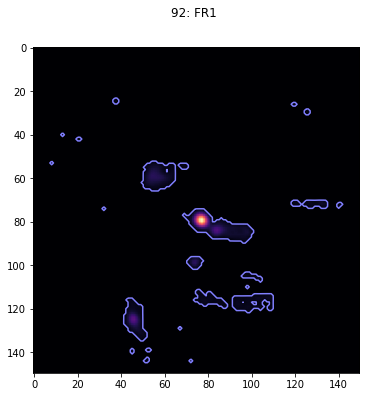

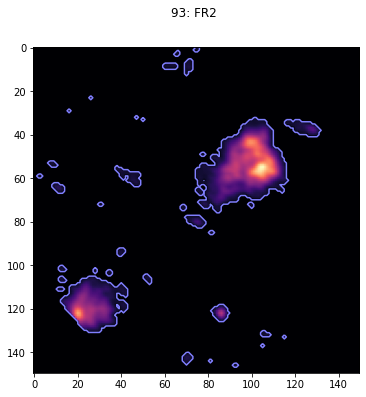

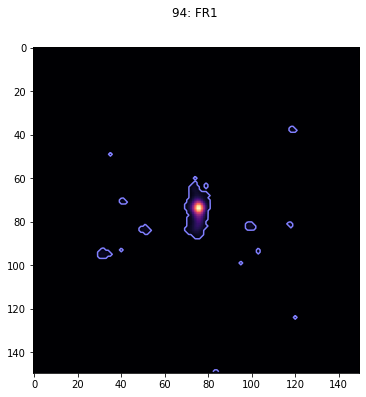

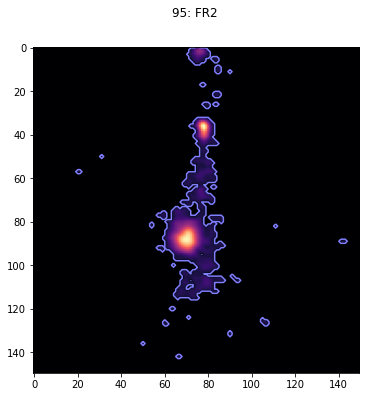

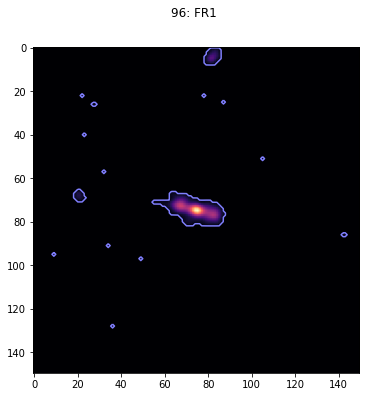

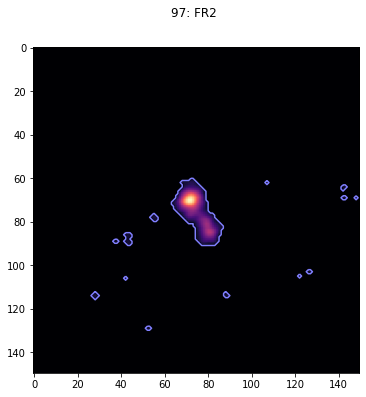

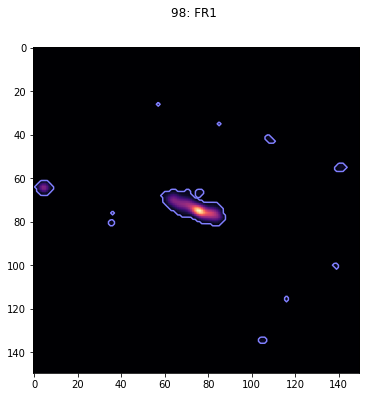

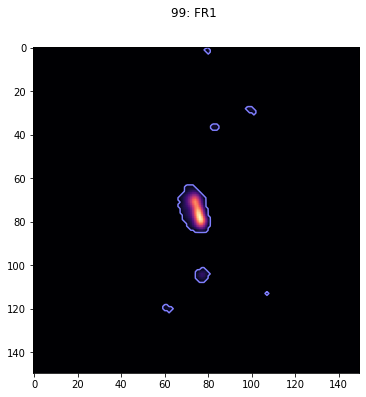

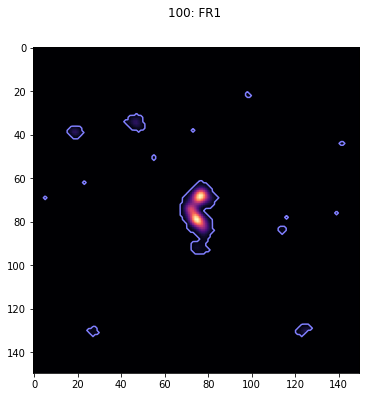

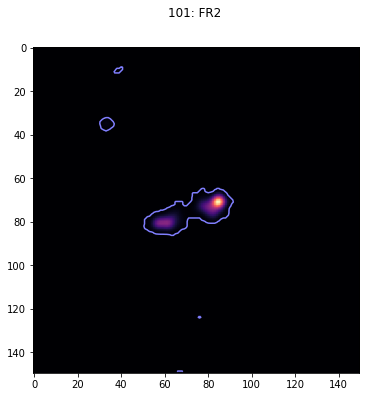

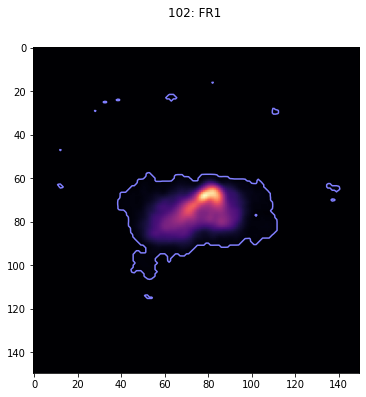

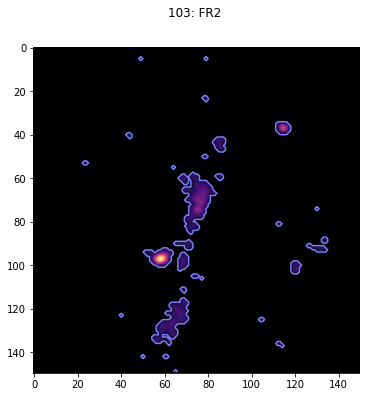

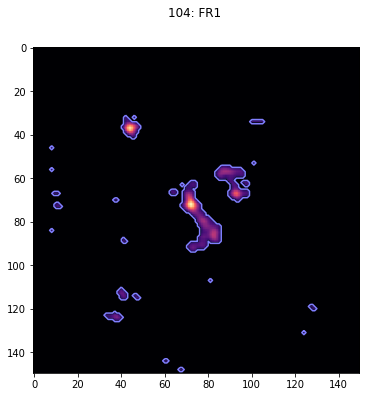

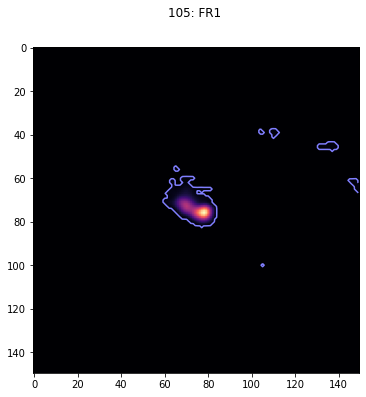

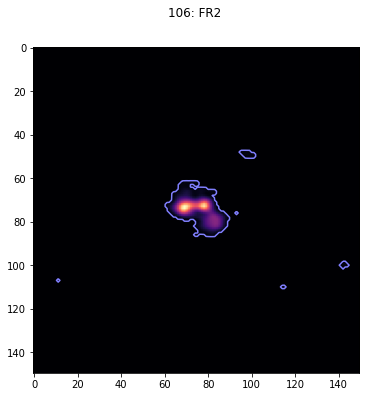

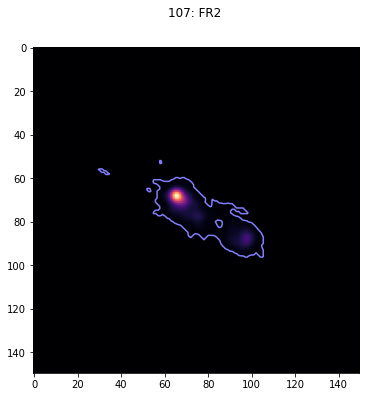

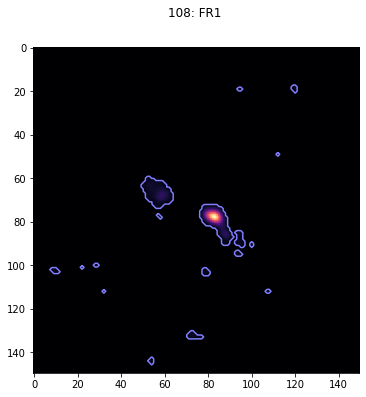

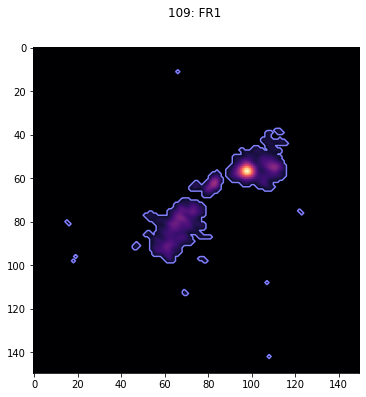

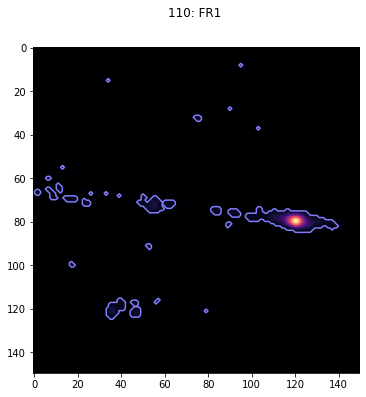

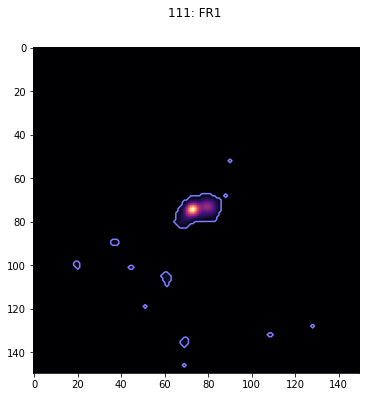

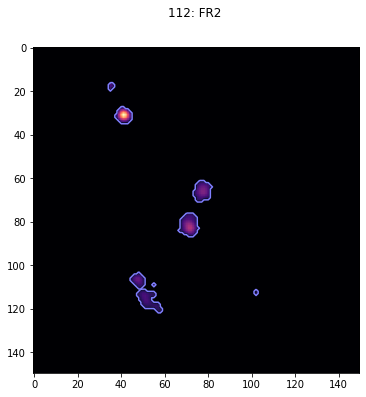

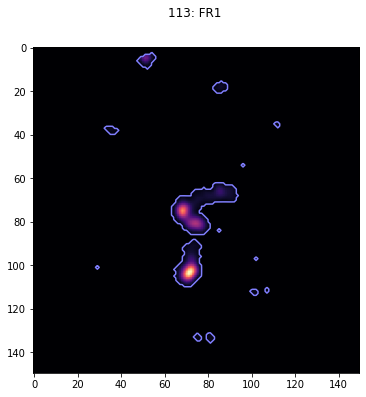

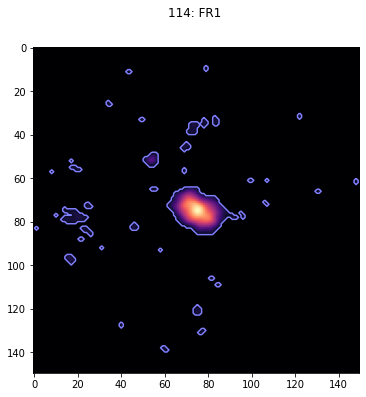

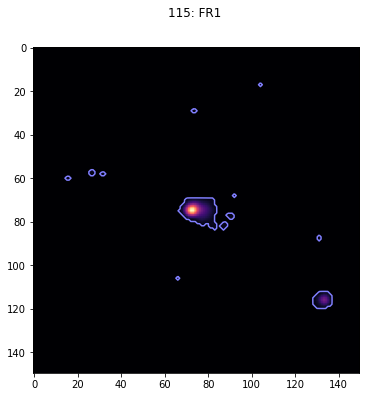

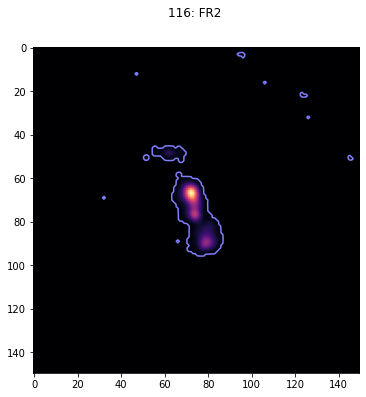

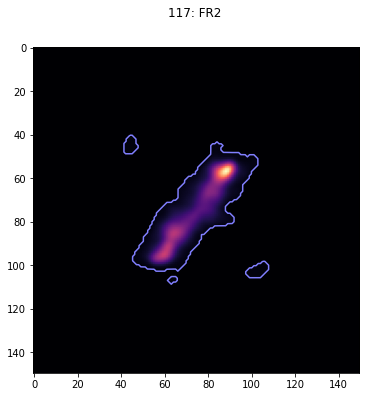

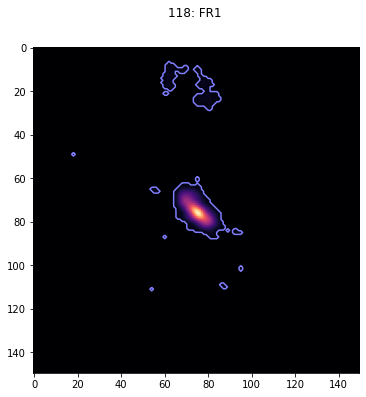

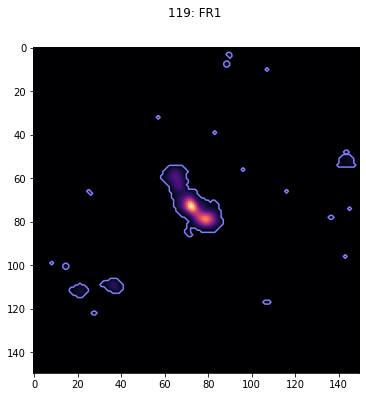

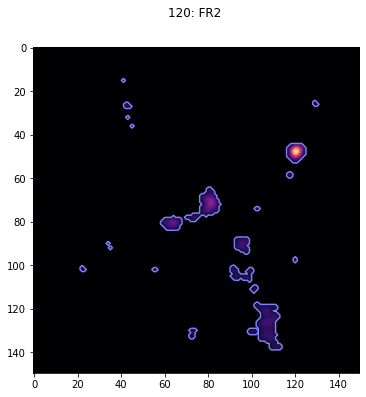

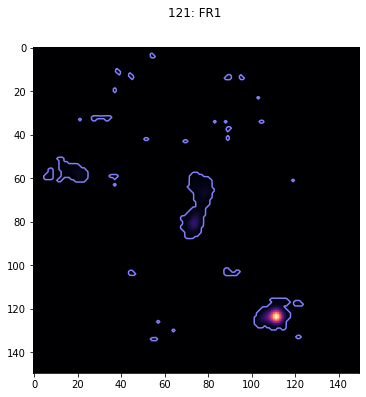

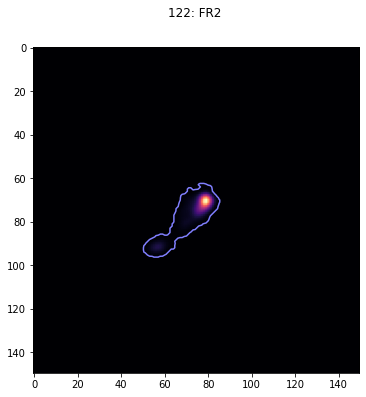

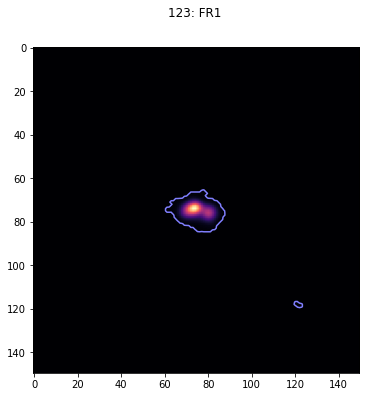

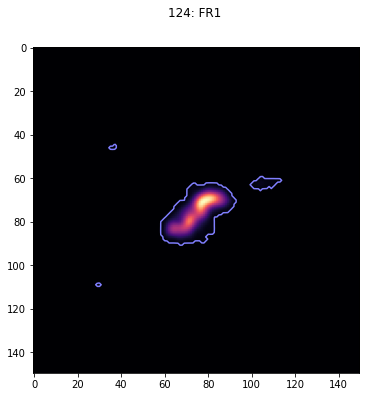

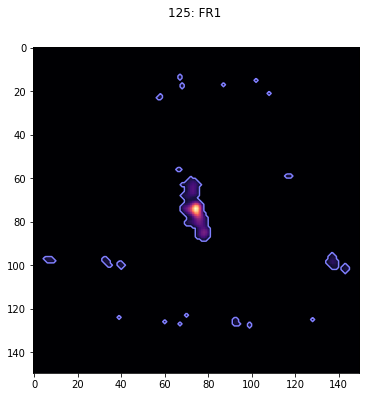

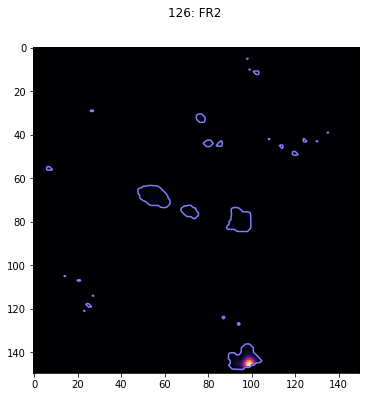

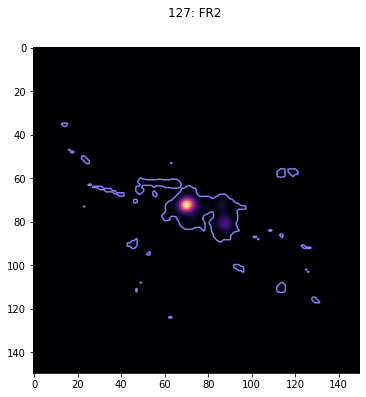

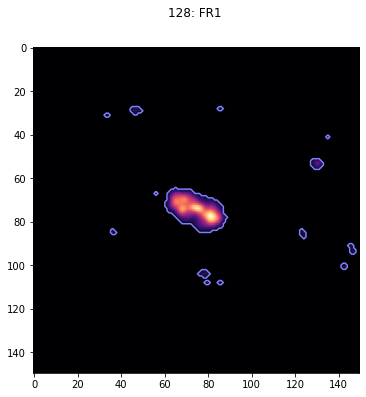

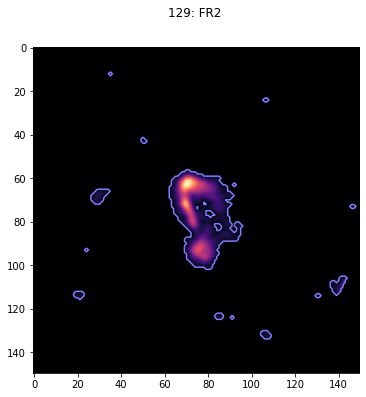

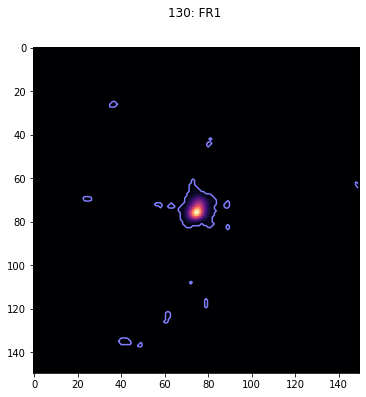

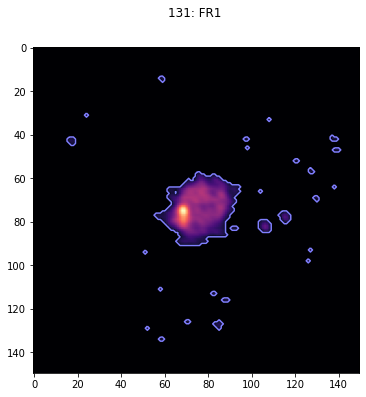

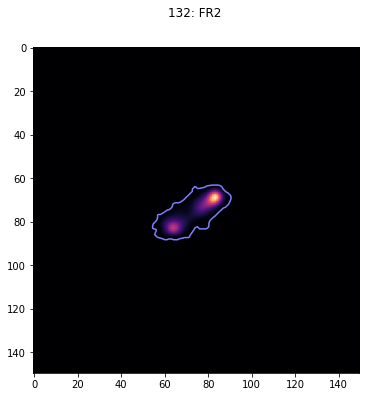

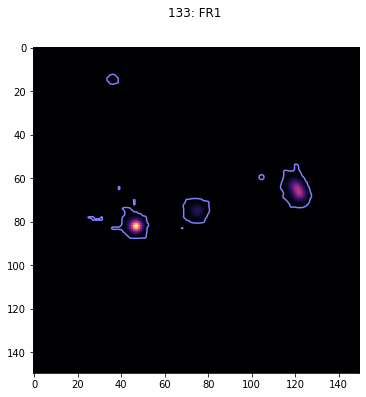

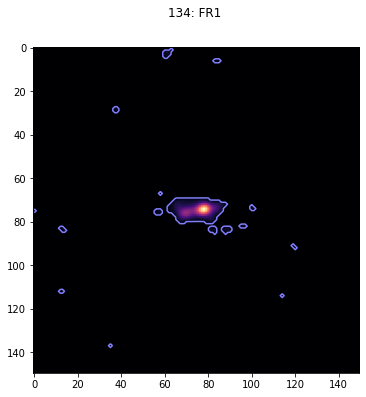

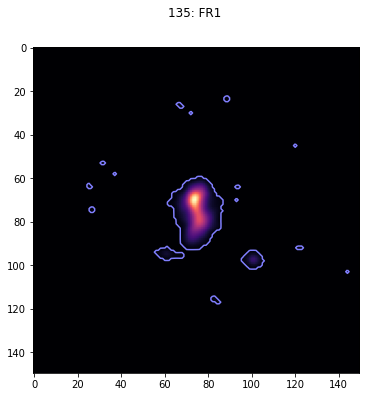

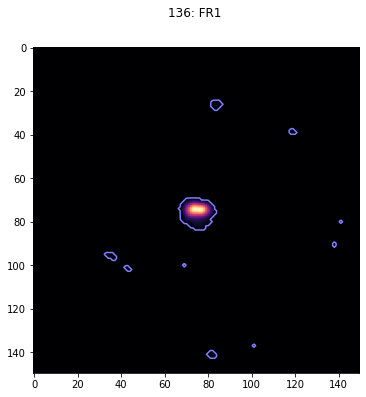

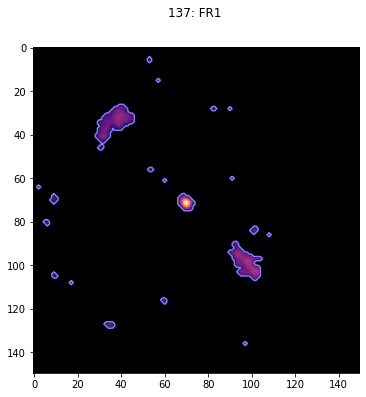

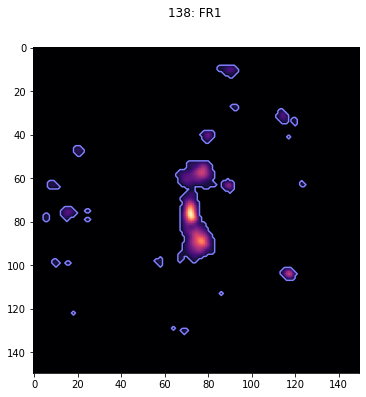

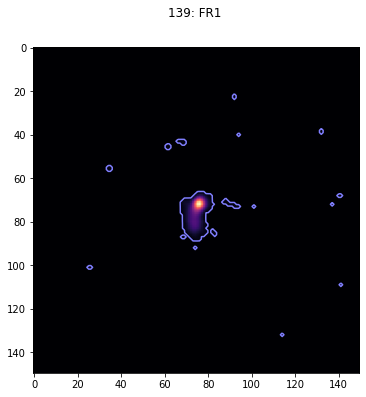

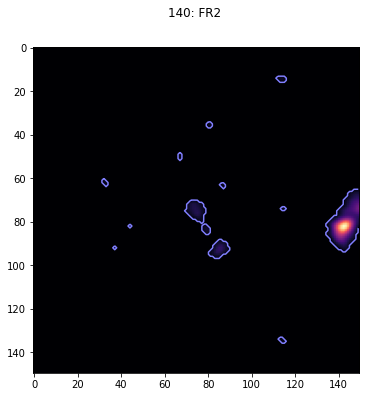

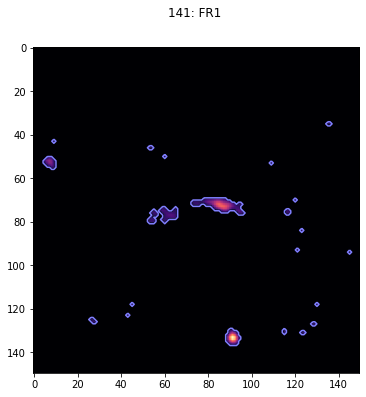

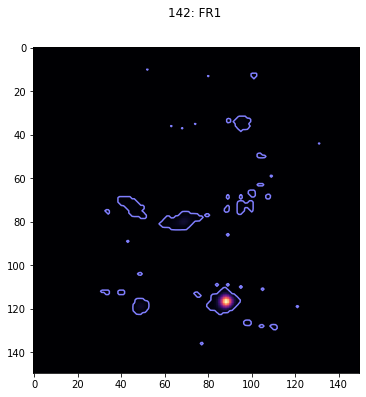

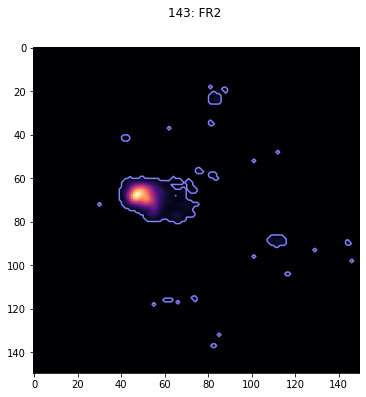

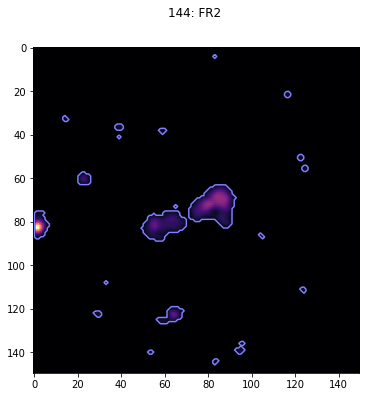

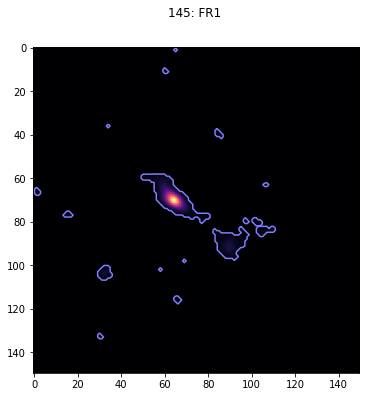

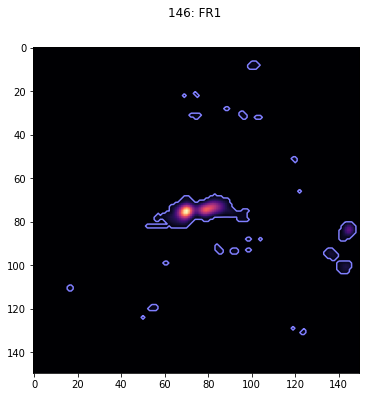

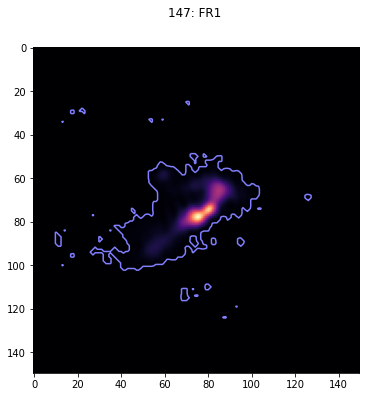

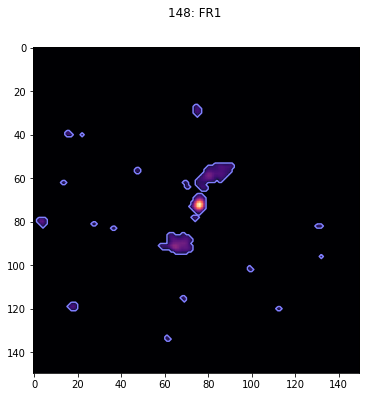

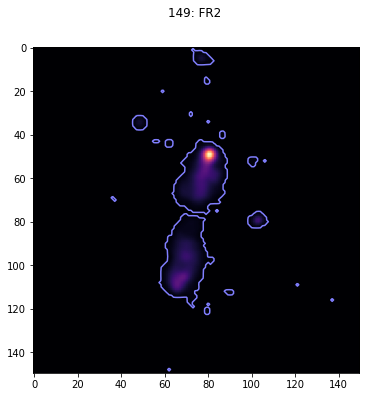

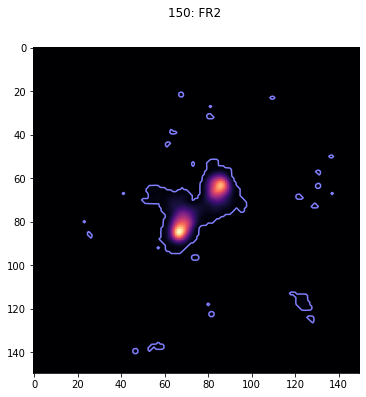

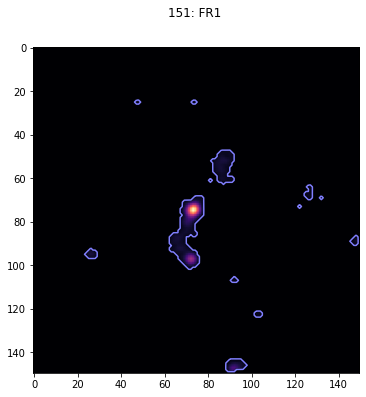

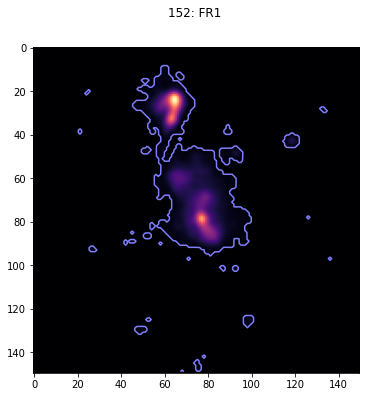

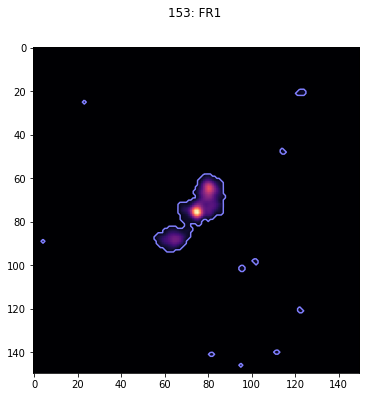

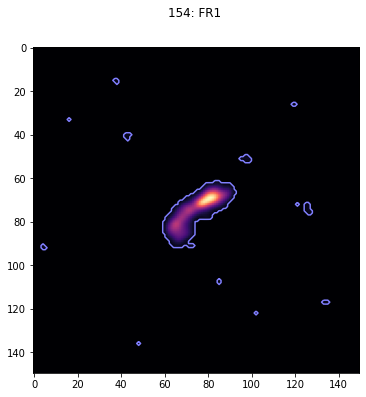

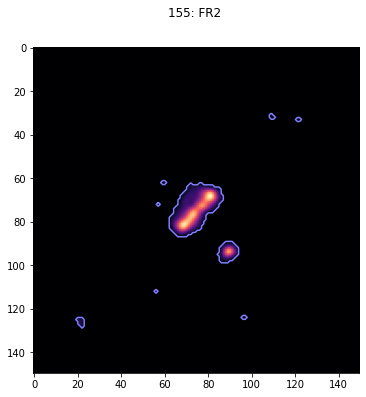

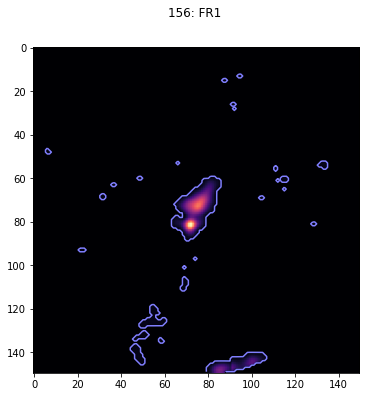

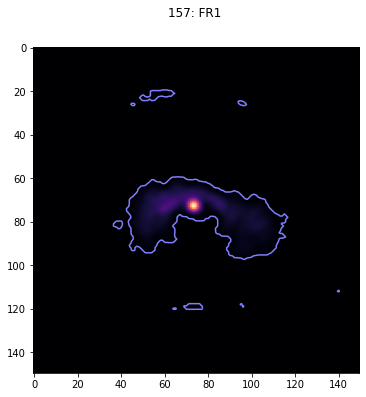

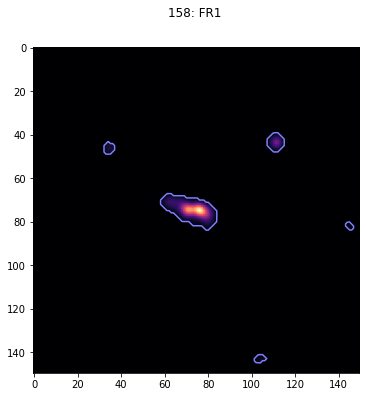

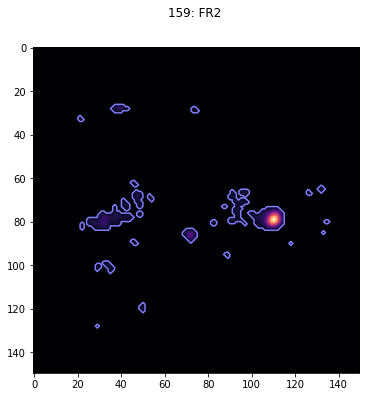

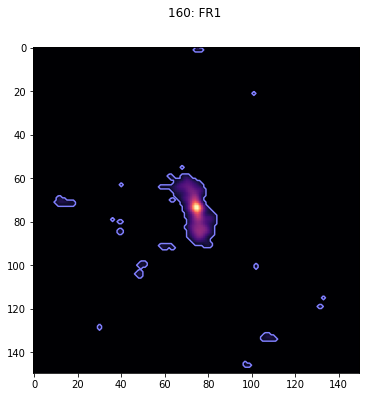

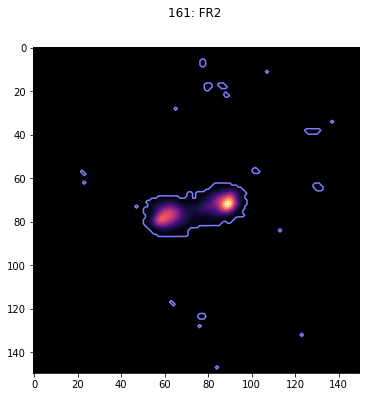

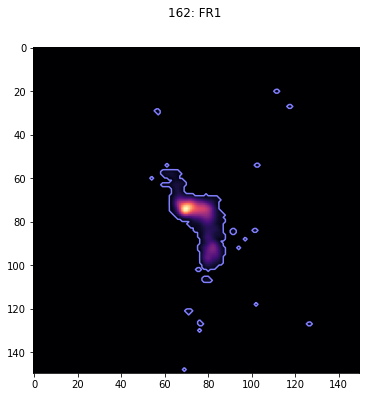

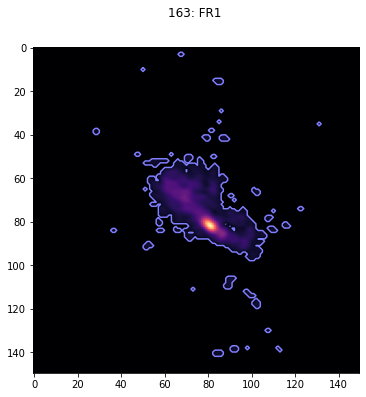

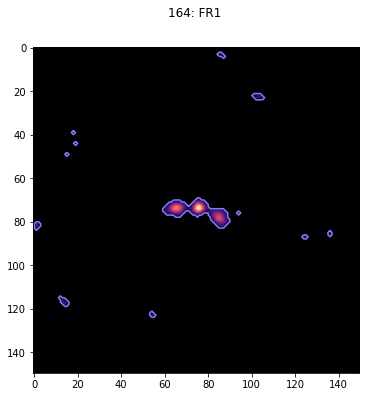

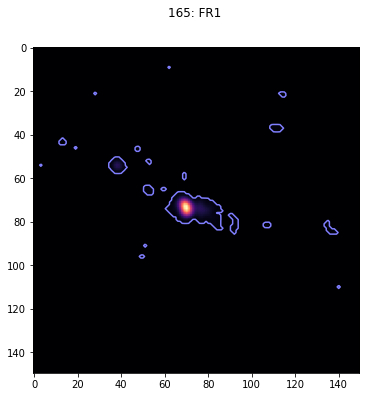

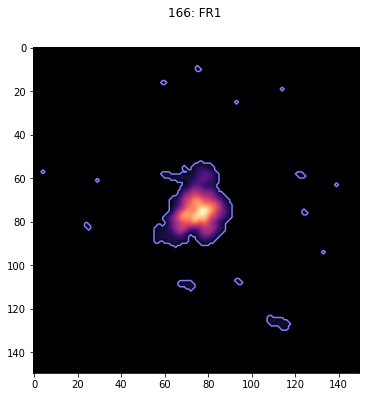

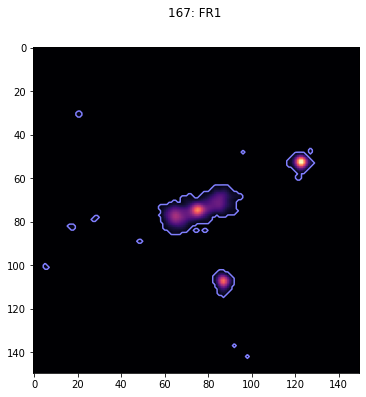

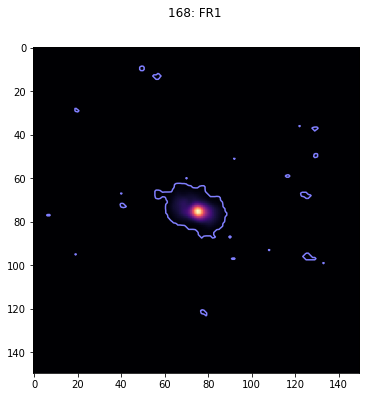

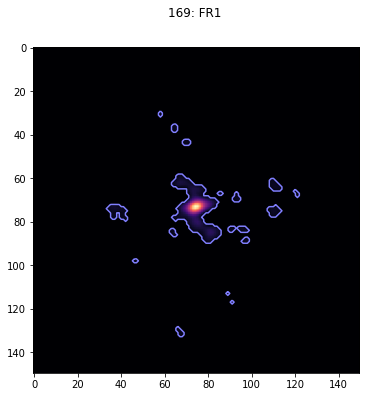

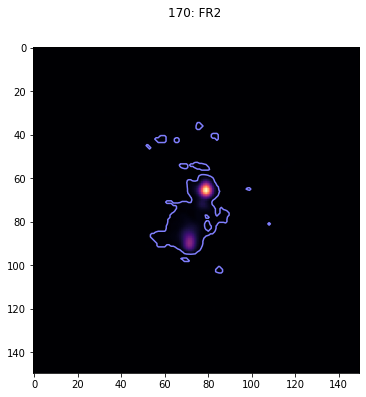

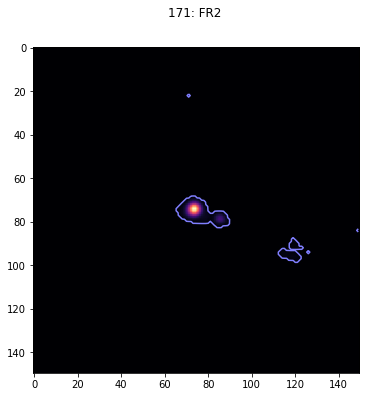

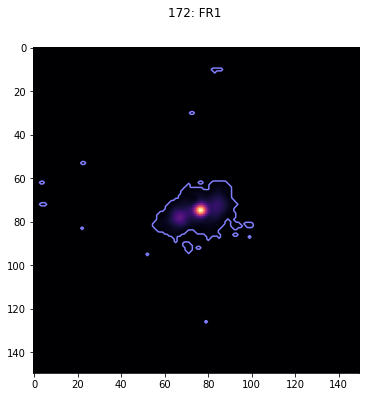

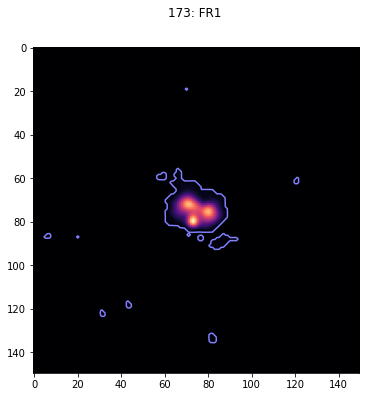

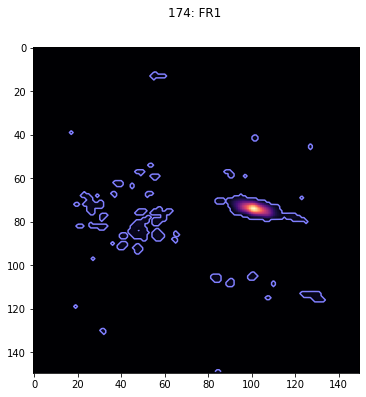

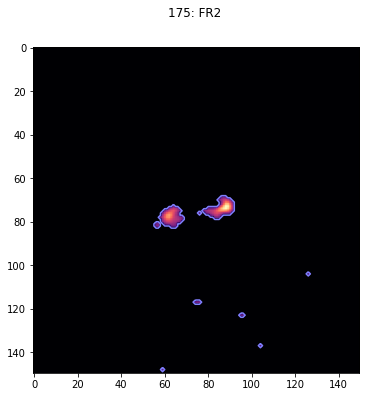

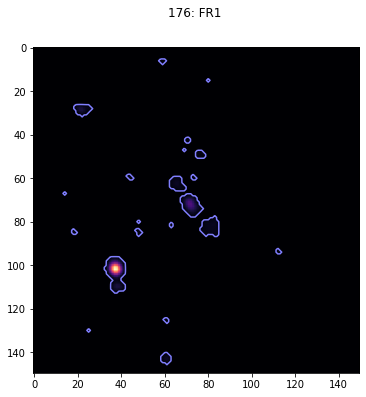

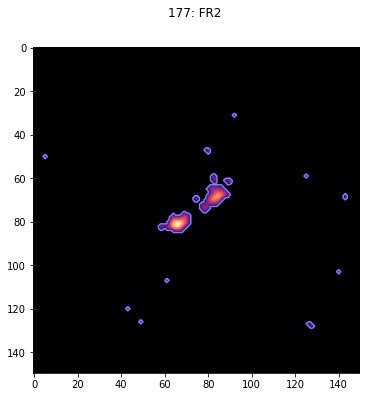

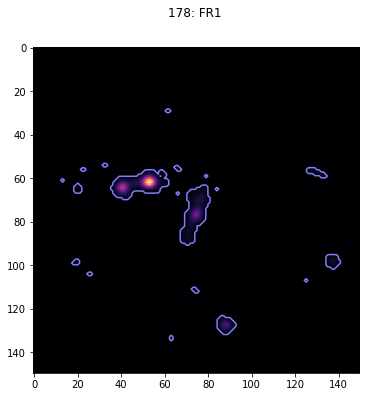

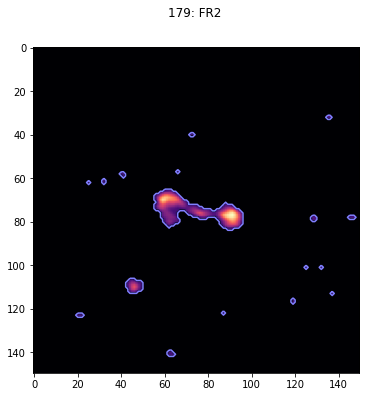

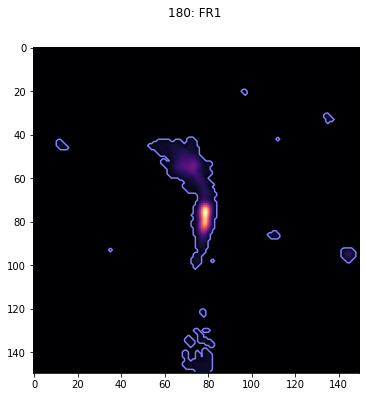

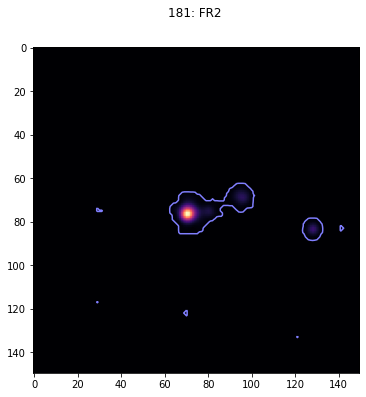

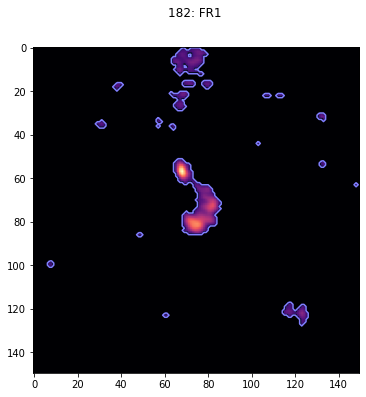

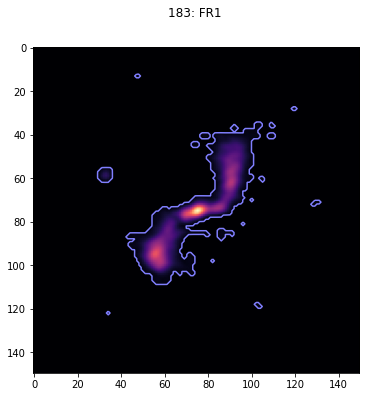

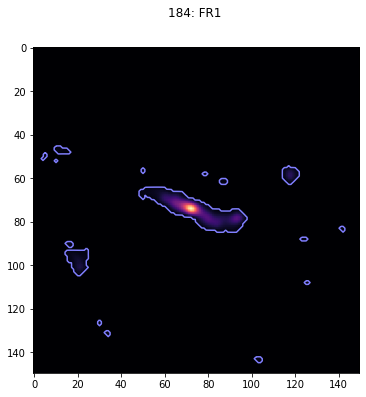

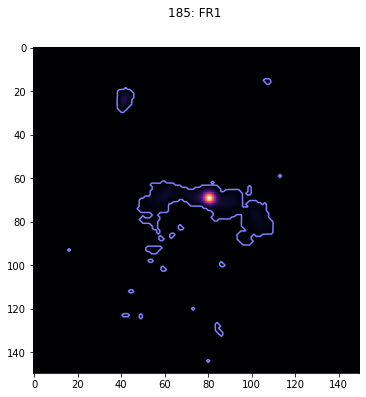

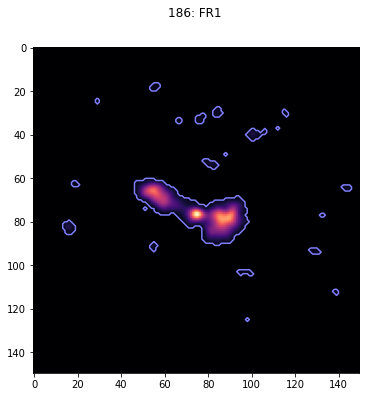

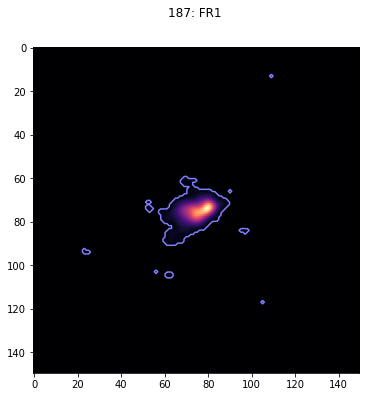

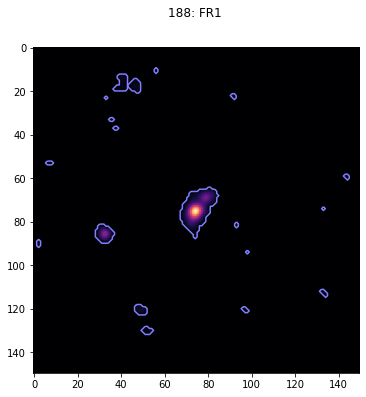

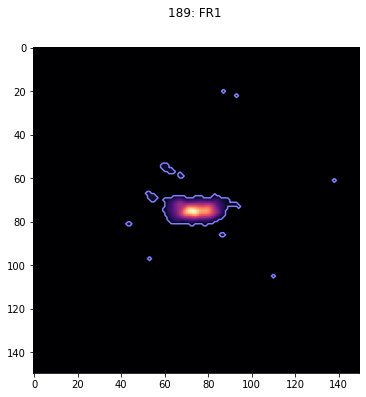

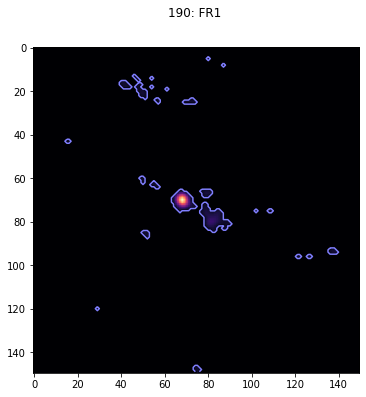

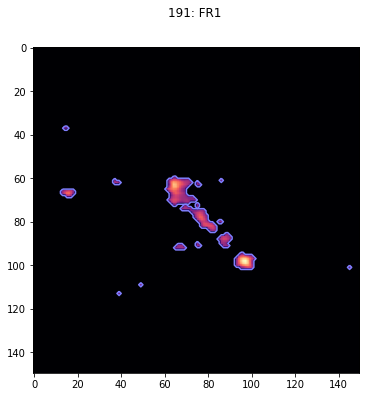

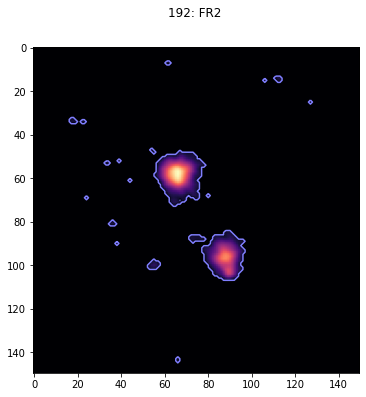

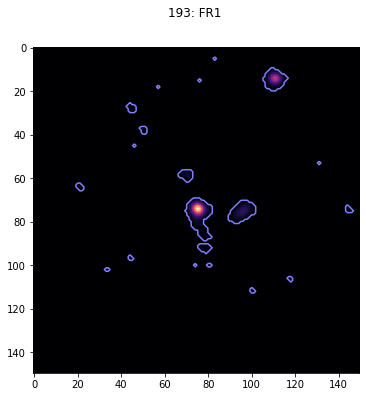

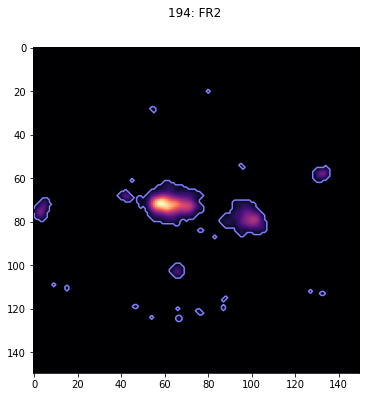

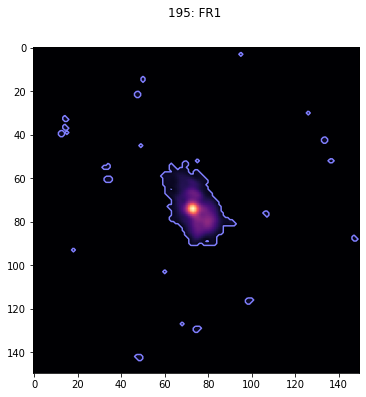

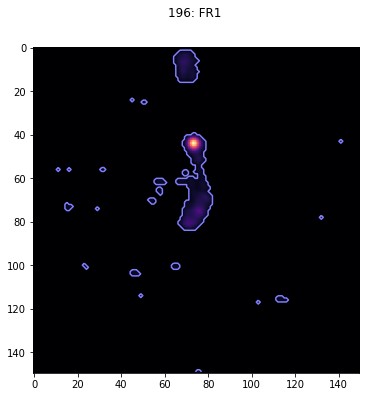

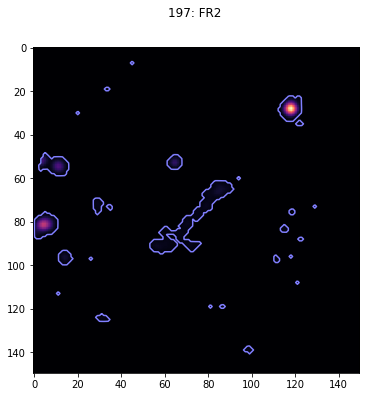

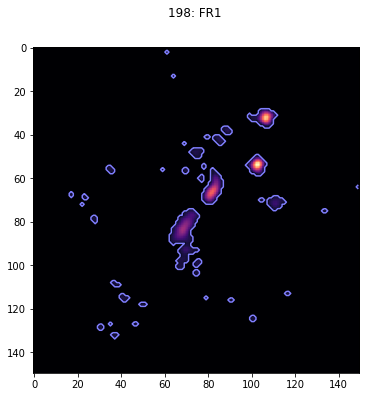

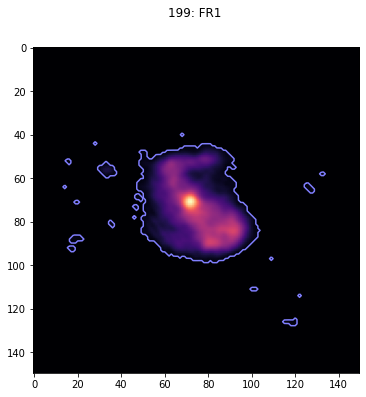

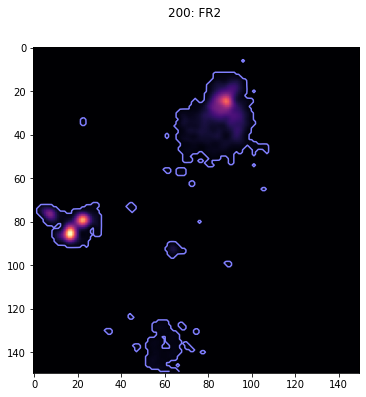

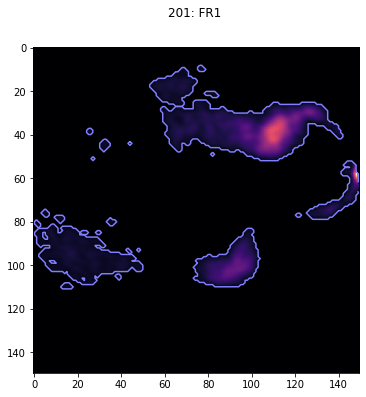

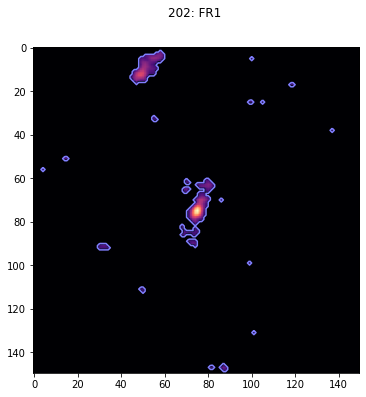

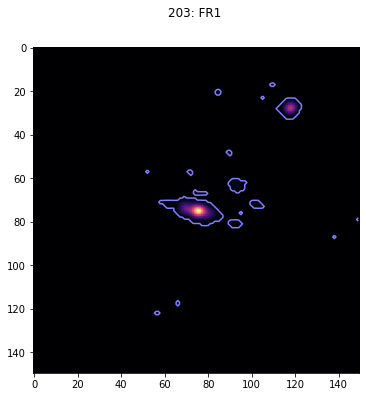

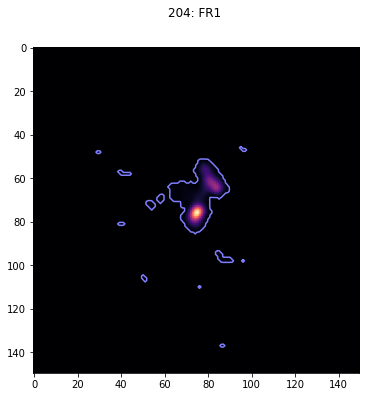

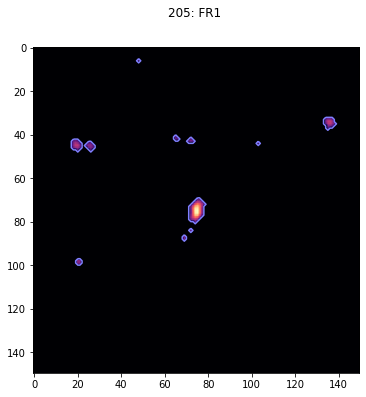

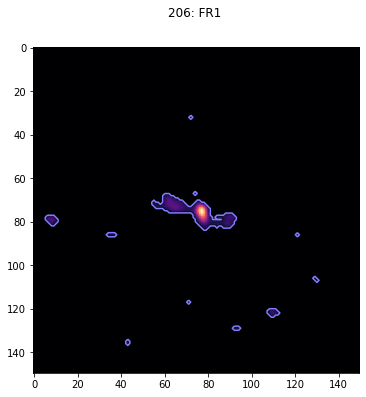

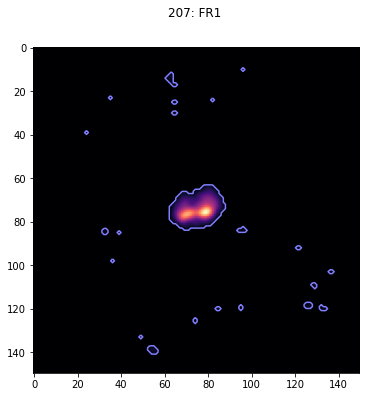

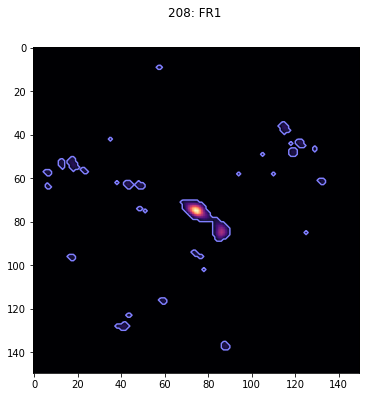

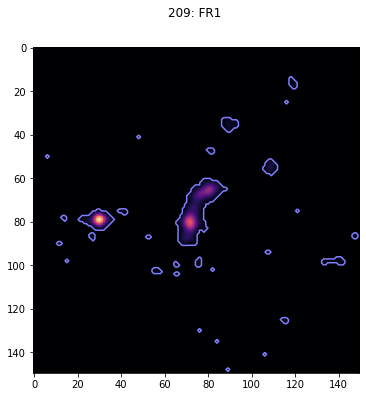

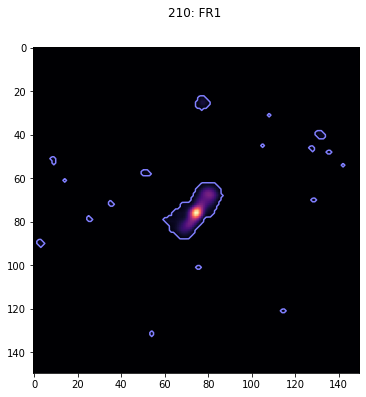

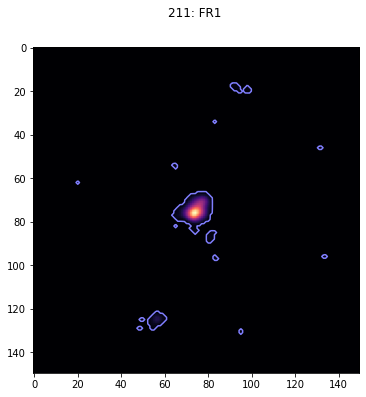

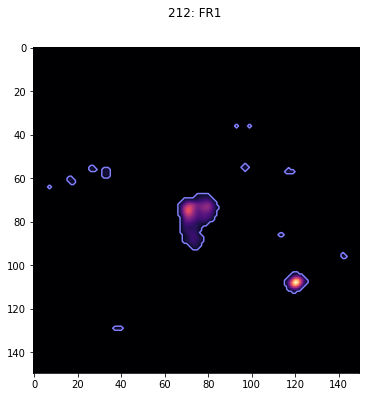

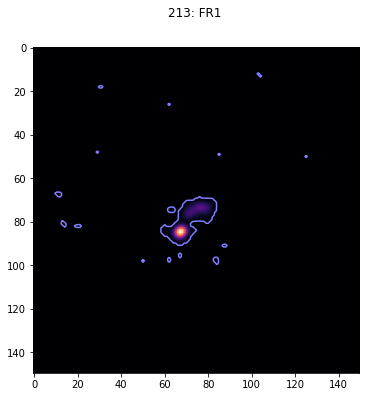

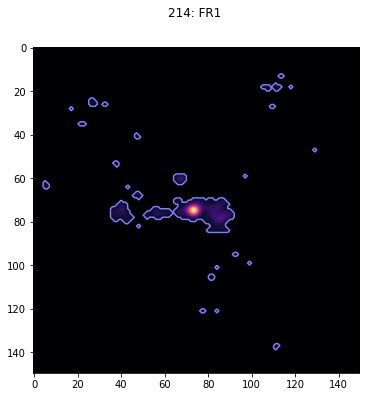

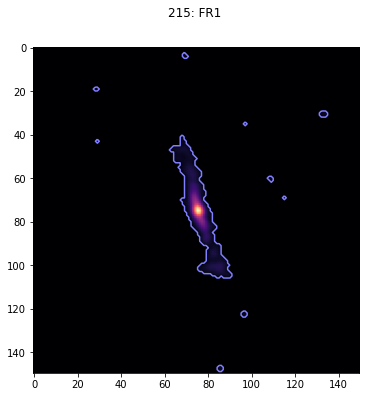

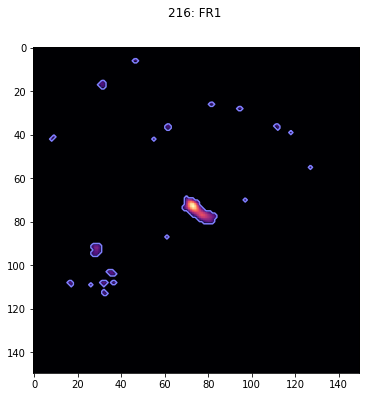

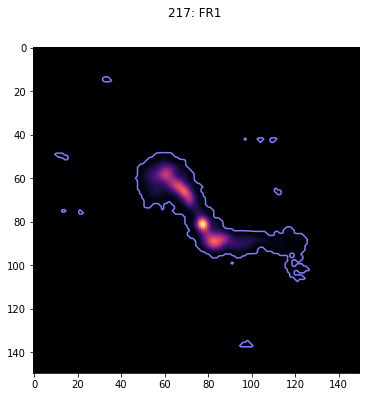

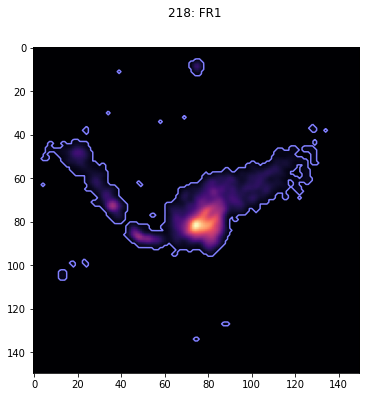

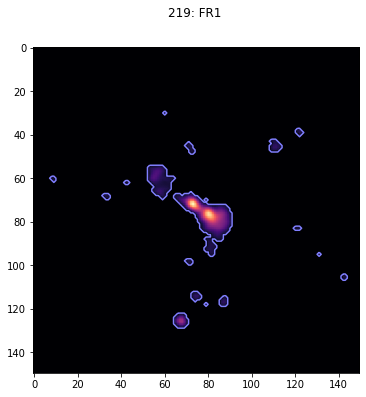

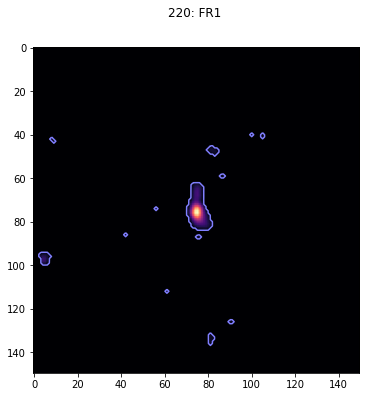

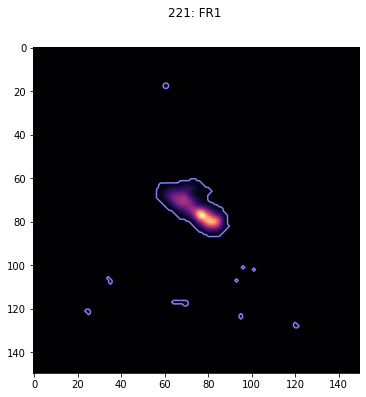

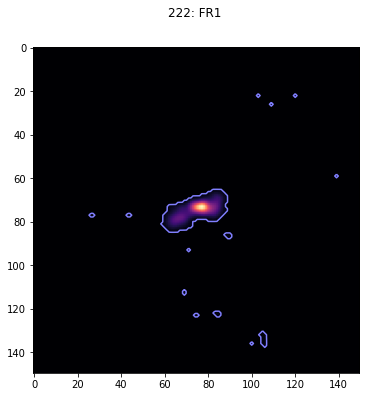

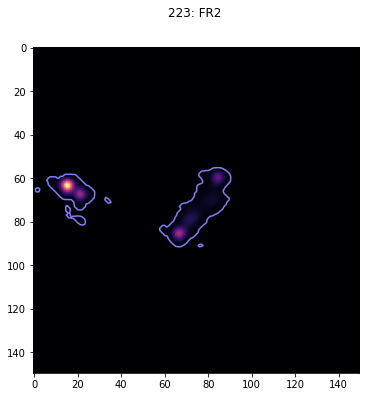

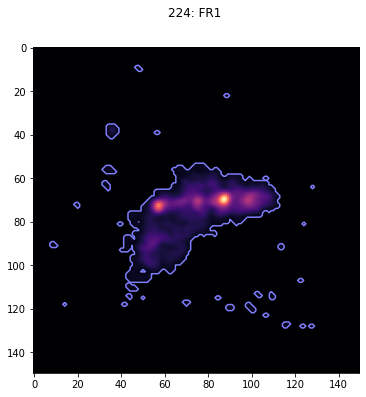

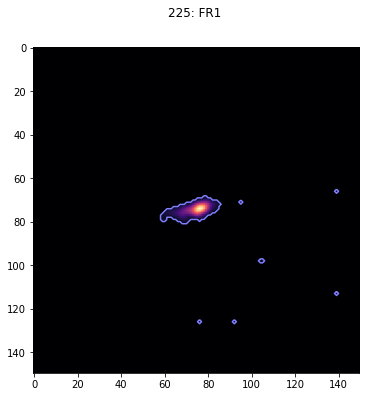

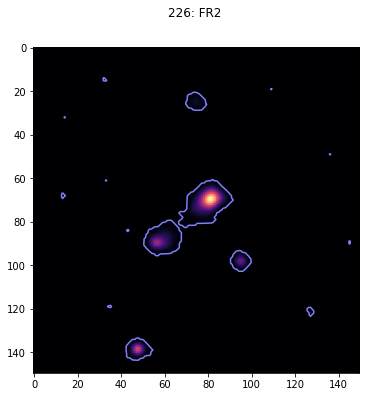

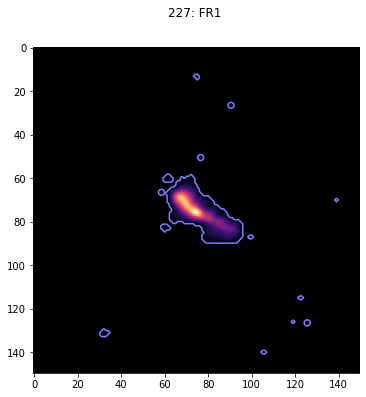

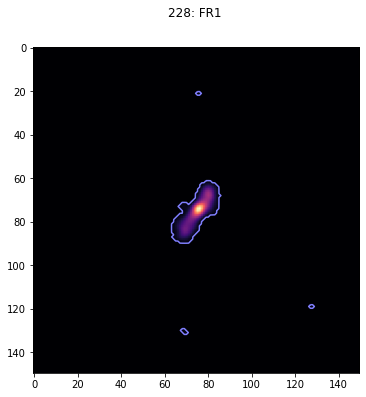

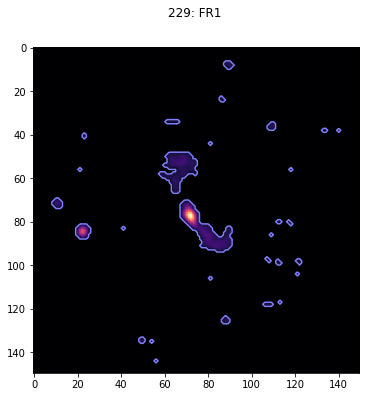

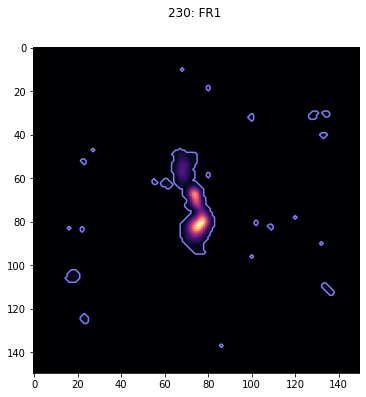

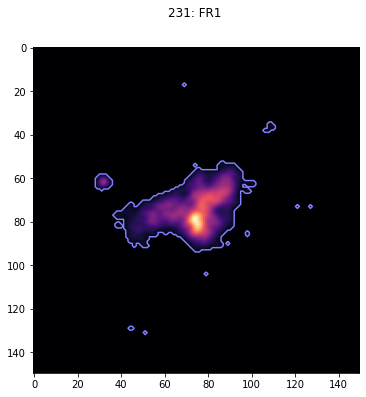

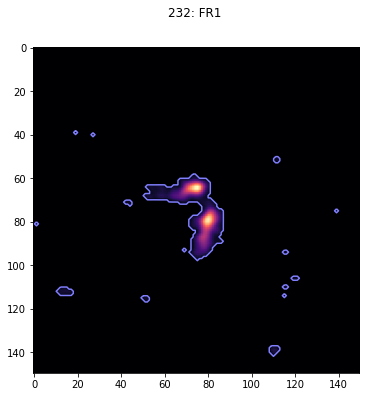

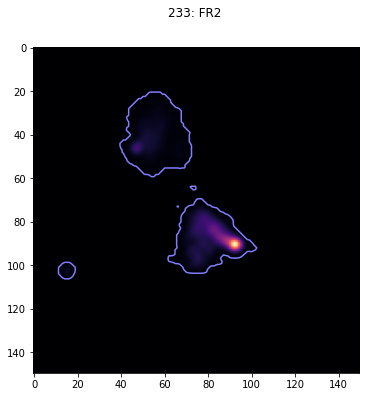

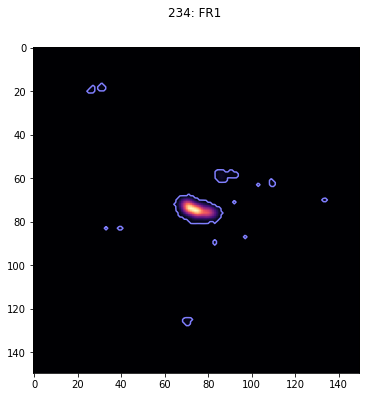

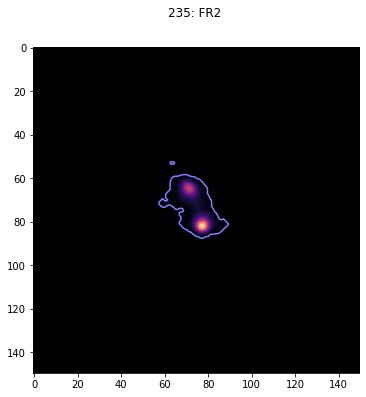

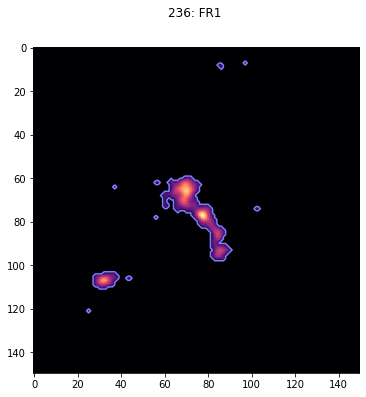

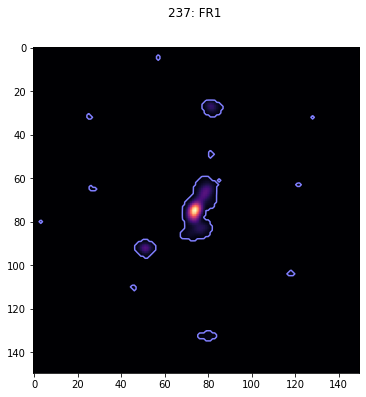

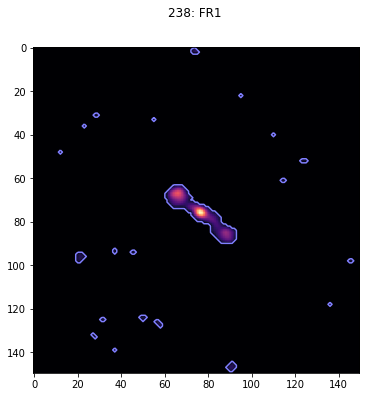

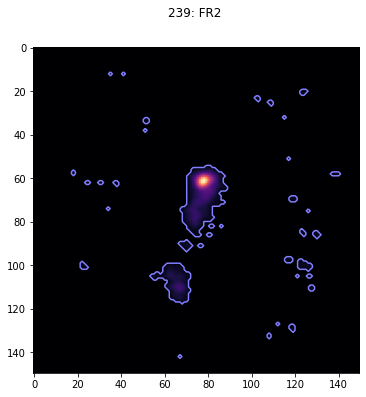

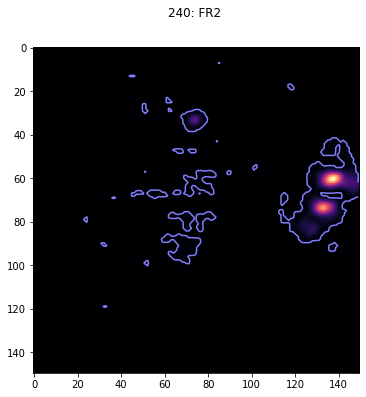

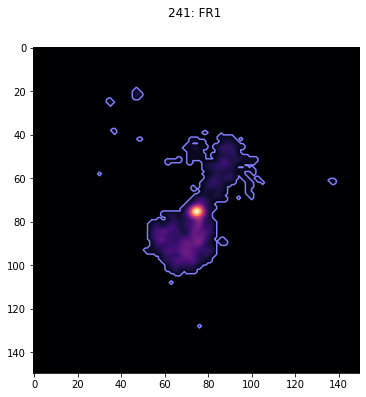

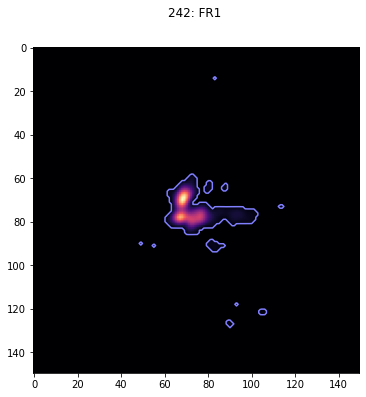

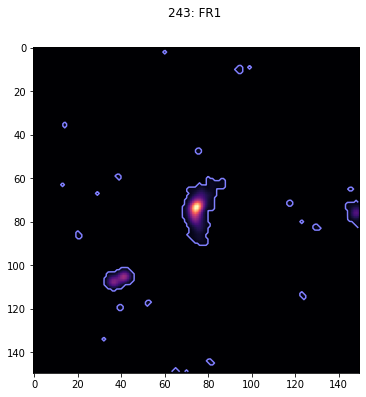

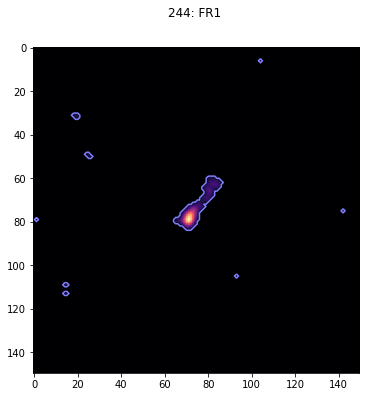

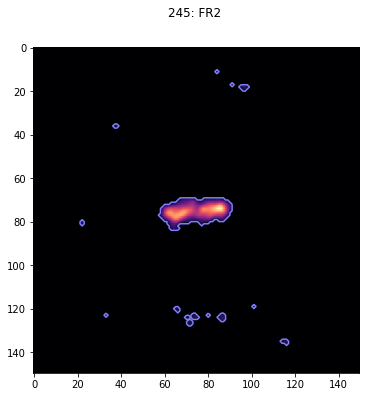

In [11]:
imgs = []
labels = []
test_data_loader = utils.data.load(config, train=False, augmentation='None', data_loader=True)    # Prepare sources and labels
for idx, (test_data, l) in enumerate(test_data_loader):
    for idy, img in enumerate(test_data):
        plt.figure(figsize=(6,6))
        plt.imshow(img.squeeze(), cmap='magma')
        plt.contour(img.squeeze(), 0, cmap='cool')
        plt.title(f"{idx*16+idy}: FR{l[idy]+1} ")
        plt.show()

## Attention Map Distributions